In [1]:
from transformers import AutoProcessor, AutoModelForCausalLM

from PIL import Image

import requests

import copy

import torch

%matplotlib inline

In [2]:
! pip install torch

/opt/conda/lib/python3.10/pty.py:89: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid, fd = os.forkpty()


In [3]:
!pip install -q transformers flash_attn timm einops peft

In [4]:
# @title Imports



import io

import os

import re

import json

import torch

import html

import base64

import itertools



import numpy as np

#import supervision as sv



#from google.colab import userdata

from IPython.core.display import display, HTML

from torch.utils.data import Dataset, DataLoader

from transformers import (

    AdamW,

    AutoModelForCausalLM,

    AutoProcessor,

    get_scheduler

)

from tqdm import tqdm

from typing import List, Dict, Any, Tuple, Generator

from peft import LoraConfig, get_peft_model

from PIL import Image

#from roboflow import Roboflow

/tmp/ipykernel_23/1412725697.py:31: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import display, HTML


In [5]:
from transformers import AutoProcessor, AutoModelForCausalLM

from PIL import Image

import requests

import copy

import torch

%matplotlib inline



model_id = "microsoft/Florence-2-large-ft"

REVISION = 'refs/pr/6'

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = AutoModelForCausalLM.from_pretrained(model_id, trust_remote_code=True, torch_dtype='auto').eval().cuda()

processor = AutoProcessor.from_pretrained(model_id, trust_remote_code=True)

config.json:   0%|          | 0.00/2.43k [00:00<?, ?B/s]

configuration_florence2.py:   0%|          | 0.00/15.1k [00:00<?, ?B/s]

A new version of the following files was downloaded from https://huggingface.co/microsoft/Florence-2-base-ft:
- configuration_florence2.py
. Make sure to double-check they do not contain any added malicious code. To avoid downloading new versions of the code file, you can pin a revision.


modeling_florence2.py:   0%|          | 0.00/127k [00:00<?, ?B/s]

A new version of the following files was downloaded from https://huggingface.co/microsoft/Florence-2-base-ft:
- modeling_florence2.py
. Make sure to double-check they do not contain any added malicious code. To avoid downloading new versions of the code file, you can pin a revision.


pytorch_model.bin:   0%|          | 0.00/464M [00:00<?, ?B/s]

Florence2LanguageForConditionalGeneration has generative capabilities, as `prepare_inputs_for_generation` is explicitly overwritten. However, it doesn't directly inherit from `GenerationMixin`. From 👉v4.50👈 onwards, `PreTrainedModel` will NOT inherit from `GenerationMixin`, and this model will lose the ability to call `generate` and other related functions.
  - If you're using `trust_remote_code=True`, you can get rid of this warning by loading the model with an auto class. See https://huggingface.co/docs/transformers/en/model_doc/auto#auto-classes
  - If you are the owner of the model architecture code, please modify your model class such that it inherits from `GenerationMixin` (after `PreTrainedModel`, otherwise you'll get an exception).
  - If you are not the owner of the model architecture class, please contact the model code owner to update it.


preprocessor_config.json:   0%|          | 0.00/806 [00:00<?, ?B/s]

processing_florence2.py:   0%|          | 0.00/46.4k [00:00<?, ?B/s]

A new version of the following files was downloaded from https://huggingface.co/microsoft/Florence-2-base-ft:
- processing_florence2.py
. Make sure to double-check they do not contain any added malicious code. To avoid downloading new versions of the code file, you can pin a revision.


tokenizer_config.json:   0%|          | 0.00/34.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.10M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

/opt/conda/lib/python3.10/site-packages/transformers/tokenization_utils_base.py:1617: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be deprecated in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


In [6]:
#!unzip /content/dataset.zip

In [7]:
# @title Define `CaptioningDataset` class



class JSONLDataset:

    def __init__(self, jsonl_file_path: str, image_directory_path: str):

        self.jsonl_file_path = jsonl_file_path

        self.image_directory_path = image_directory_path

        self.entries = self._load_entries()



    def _load_entries(self) -> List[Dict[str, Any]]:

        entries = []

        with open(self.jsonl_file_path, 'r') as file:

            for line in file:

                data = json.loads(line)

                entries.append(data)

        return entries



    def __len__(self) -> int:

        return len(self.entries)



    def __getitem__(self, idx: int) -> Tuple[Image.Image, Dict[str, Any]]:

        if idx < 0 or idx >= len(self.entries):

            raise IndexError("Index out of range")



        entry = self.entries[idx]

        image_path = os.path.join(self.image_directory_path, entry['image'])

        try:

            image = Image.open(image_path)

            return (image, entry)

        except FileNotFoundError:

            raise FileNotFoundError(f"Image file {image_path} not found.")





class CaptioningDataset(Dataset):

    def __init__(self, jsonl_file_path: str, image_directory_path: str):

        self.dataset = JSONLDataset(jsonl_file_path, image_directory_path)



    def __len__(self):

        return len(self.dataset)



    def __getitem__(self, idx):

        image, data = self.dataset[idx]

        prefix = "<MORE_DETAILED_CAPTION>"

        suffix = data['suffix']

        return prefix, suffix, image

In [8]:
# @title Initiate `CaptioningDataset` and `DataLoader` for train and validation subsets



BATCH_SIZE = 2

NUM_WORKERS = 0



def collate_fn(batch):

    questions, answers, images = zip(*batch)

    inputs = processor(text=list(questions), images=list(images), return_tensors="pt", padding=True).to(DEVICE)

    return inputs, answers



train_dataset = CaptioningDataset(

    jsonl_file_path = "/kaggle/input/augmenteddataset/train/preprocessed_train.jsonl",

    image_directory_path = "/kaggle/input/augmenteddataset/train"

)

val_dataset = CaptioningDataset(

    jsonl_file_path = "/kaggle/input/augmenteddataset/valid/preprocessed_valid.jsonl",

    image_directory_path = "/kaggle/input/augmenteddataset/valid"

)



train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, collate_fn=collate_fn, num_workers=NUM_WORKERS, shuffle=True)

val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, collate_fn=collate_fn, num_workers=NUM_WORKERS)

In [9]:
# @title Setup LoRA Florence-2 model



config = LoraConfig(

    r=8,

    lora_alpha=8,

    target_modules=["q_proj", "o_proj", "k_proj", "v_proj", "linear", "Conv2d", "lm_head", "fc2"],

    task_type="CAUSAL_LM",

    lora_dropout=0.5,

    bias="none",

    inference_mode=False,

    use_rslora=True,

    init_lora_weights="gaussian",

    revision=REVISION

)



peft_model = get_peft_model(model, config)

peft_model.print_trainable_parameters()

trainable params: 1,929,928 || all params: 272,733,896 || trainable%: 0.7076


In [10]:
torch.cuda.empty_cache()

In [11]:
model = model.to(torch.float32)


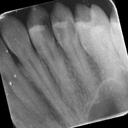
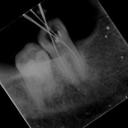
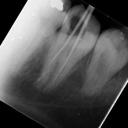
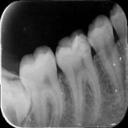

In [12]:
from PIL import Image

import io

import base64

import json

import html

from IPython.display import display, HTML



def render_inline(image: Image.Image, resize=(128, 128)):

    """Convert image into inline html."""

    image = image.resize(resize)

    with io.BytesIO() as buffer:

        image.save(buffer, format='jpeg')

        image_b64 = str(base64.b64encode(buffer.getvalue()), "utf-8")

        return f"data:image/jpeg;base64,{image_b64}"



def render_example(image: Image.Image, caption: str):

    """Render image and caption as HTML."""

    return f"""

<div style="display: inline-flex; align-items: center; justify-content: center;">

    <img style="width:256px; height:256px;" src="{render_inline(image, resize=(128, 128))}" />

    <p style="width:512px; margin:10px; font-size:small;">{html.escape(caption)}</p>

</div>

"""



def render_inference_results(model, dataset: CaptioningDataset, count: int):

    html_out = ""

    count = min(count, len(dataset))

    for i in range(count):

        image, data = dataset.dataset[i]

        prefix = "<MORE_DETAILED_CAPTION>"

        inputs = processor(text=prefix, images=image, return_tensors="pt").to(DEVICE)

        generated_ids = model.generate(

            input_ids=inputs["input_ids"],

            pixel_values=inputs["pixel_values"],

            max_new_tokens=1024,

            num_beams=3

        )

        generated_text = processor.batch_decode(generated_ids, skip_special_tokens=True)[0]

        caption = generated_text.strip()  # Process and clean up the generated text

        html_out += render_example(image, caption)



    display(HTML(html_out))



# Run the updated function to display image captions

render_inference_results(peft_model, val_dataset, 4)


In [13]:
import os

import torch

from torch.cuda.amp import GradScaler, autocast

from tqdm import tqdm

import matplotlib.pyplot as plt

from transformers import AdamW, get_scheduler



def train_model(train_loader, val_loader, model, processor, epochs=10, lr=1e-6):

    optimizer = AdamW(model.parameters(), lr=lr)

    num_training_steps = epochs * len(train_loader)

    lr_scheduler = get_scheduler(

        name="linear",

        optimizer=optimizer,

        num_warmup_steps=0,

        num_training_steps=num_training_steps,

    )



    # Initialize GradScaler for mixed precision training

    scaler = GradScaler()



    # Lists to store losses

    train_losses = []

    val_losses = []



    for epoch in range(epochs):

        model.train()

        train_loss = 0

        for inputs, answers in tqdm(train_loader, desc=f"Training Epoch {epoch + 1}/{epochs}"):

            input_ids = inputs["input_ids"].to(DEVICE)

            pixel_values = inputs["pixel_values"].to(DEVICE)

            labels = processor.tokenizer(

                text=answers,

                return_tensors="pt",

                padding=True,

                truncation=True,

                return_token_type_ids=False

            ).input_ids.to(DEVICE)



            # Mixed precision training

            with autocast():

                outputs = model(input_ids=input_ids, pixel_values=pixel_values, labels=labels)

                loss = outputs.loss



            scaler.scale(loss).backward()

            scaler.step(optimizer)

            scaler.update()

            optimizer.zero_grad()

            lr_scheduler.step()



            train_loss += loss.item()



            # Clear GPU cache

            torch.cuda.empty_cache()



        avg_train_loss = train_loss / len(train_loader)

        train_losses.append(avg_train_loss)

        print(f"Epoch {epoch + 1}: Average Training Loss: {avg_train_loss}")



        model.eval()

        val_loss = 0

        with torch.no_grad():

            for inputs, answers in tqdm(val_loader, desc=f"Validation Epoch {epoch + 1}/{epochs}"):

                input_ids = inputs["input_ids"].to(DEVICE)

                pixel_values = inputs["pixel_values"].to(DEVICE)

                labels = processor.tokenizer(

                    text=answers,

                    return_tensors="pt",

                    padding=True,

                    truncation=True,

                    return_token_type_ids=False

                ).input_ids.to(DEVICE)



                outputs = model(input_ids=input_ids, pixel_values=pixel_values, labels=labels)

                loss = outputs.loss



                val_loss += loss.item()



            avg_val_loss = val_loss / len(val_loader)

            val_losses.append(avg_val_loss)

            print(f"Epoch {epoch + 1}: Average Validation Loss: {avg_val_loss}")



            # Render inference results for validation data

            render_inference_results(model, val_loader.dataset, 6)



        # Save model and processor checkpoint

        output_dir = f"./model_checkpoints/epoch_{epoch+1}"

        os.makedirs(output_dir, exist_ok=True)

        model.save_pretrained(output_dir)

        processor.save_pretrained(output_dir)



    # Plot the loss curves

    plt.figure(figsize=(12, 6))

    plt.plot(range(1, epochs + 1), train_losses, label='Training Loss', marker='o')

    plt.plot(range(1, epochs + 1), val_losses, label='Validation Loss', marker='o')

    plt.xlabel('Epoch')

    plt.ylabel('Loss')

    plt.title('Training and Validation Loss Curves')

    plt.legend()

    plt.savefig('loss_curves.png')  # Save the plot as a PNG file

    plt.show()


/opt/conda/lib/python3.10/site-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
/tmp/ipykernel_23/12300317.py:37: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()
Training Epoch 1/100:   0%|          | 0/161 [00:00<?, ?it/s]/tmp/ipykernel_23/12300317.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
Training Epoch 1/100: 100%|██████████| 161/161 [02:14<00:00,  1.19it/s]


Epoch 1: Average Training Loss: 1.0897326656380055


Validation Epoch 1/100: 100%|██████████| 139/139 [00:42<00:00,  3.27it/s]


Epoch 1: Average Validation Loss: 0.5672905438666721



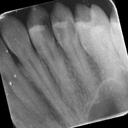
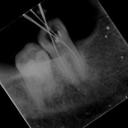
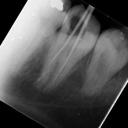
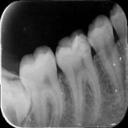
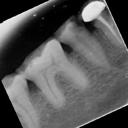
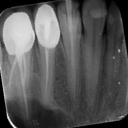

/opt/conda/lib/python3.10/site-packages/peft/utils/save_and_load.py:227: UserWarning: Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.
  warnings.warn("Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.")
Training Epoch 2/100: 100%|██████████| 161/161 [02:12<00:00,  1.21it/s]


Epoch 2: Average Training Loss: 0.6396754863469497


Validation Epoch 2/100: 100%|██████████| 139/139 [00:41<00:00,  3.36it/s]


Epoch 2: Average Validation Loss: 0.5161643797973935



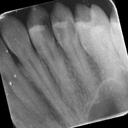
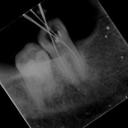
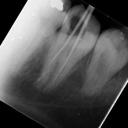
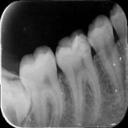
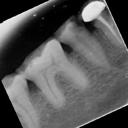
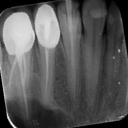

Training Epoch 3/100: 100%|██████████| 161/161 [02:13<00:00,  1.21it/s]


Epoch 3: Average Training Loss: 0.5723411927682273


Validation Epoch 3/100: 100%|██████████| 139/139 [00:41<00:00,  3.33it/s]


Epoch 3: Average Validation Loss: 0.46329188121737336



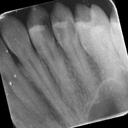
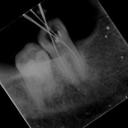
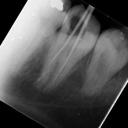
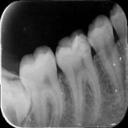
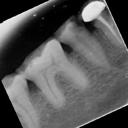
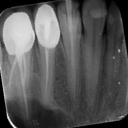

Training Epoch 4/100: 100%|██████████| 161/161 [02:13<00:00,  1.21it/s]


Epoch 4: Average Training Loss: 0.5014773750712412


Validation Epoch 4/100: 100%|██████████| 139/139 [00:41<00:00,  3.34it/s]


Epoch 4: Average Validation Loss: 0.42324651091647664



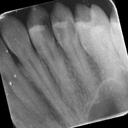
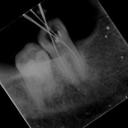
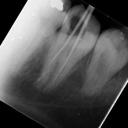
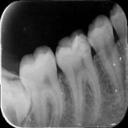
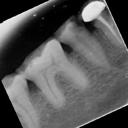
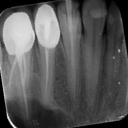

Training Epoch 5/100: 100%|██████████| 161/161 [02:13<00:00,  1.21it/s]


Epoch 5: Average Training Loss: 0.47788213660813267


Validation Epoch 5/100: 100%|██████████| 139/139 [00:41<00:00,  3.32it/s]


Epoch 5: Average Validation Loss: 0.42734814041274055



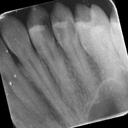
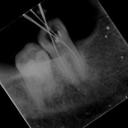
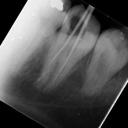
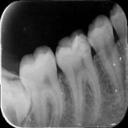
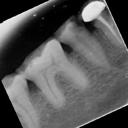
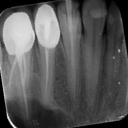

Training Epoch 6/100: 100%|██████████| 161/161 [02:13<00:00,  1.21it/s]


Epoch 6: Average Training Loss: 0.4514360803162089


Validation Epoch 6/100: 100%|██████████| 139/139 [00:41<00:00,  3.32it/s]


Epoch 6: Average Validation Loss: 0.4567110708934798



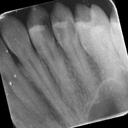
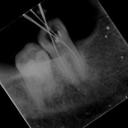
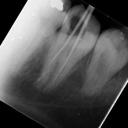
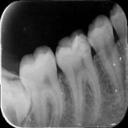
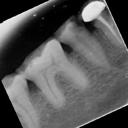
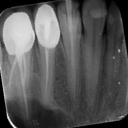

Training Epoch 7/100: 100%|██████████| 161/161 [02:13<00:00,  1.21it/s]


Epoch 7: Average Training Loss: 0.42947624003665047


Validation Epoch 7/100: 100%|██████████| 139/139 [00:41<00:00,  3.33it/s]


Epoch 7: Average Validation Loss: 0.39931685102286096



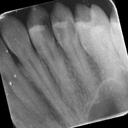
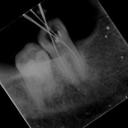
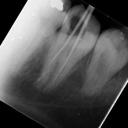
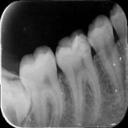
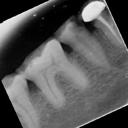
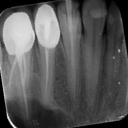

Training Epoch 8/100: 100%|██████████| 161/161 [02:13<00:00,  1.20it/s]


Epoch 8: Average Training Loss: 0.41110644410856023


Validation Epoch 8/100: 100%|██████████| 139/139 [00:41<00:00,  3.32it/s]


Epoch 8: Average Validation Loss: 0.406827833557086



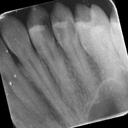
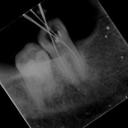
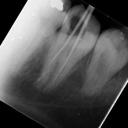
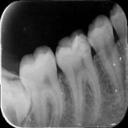
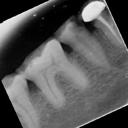
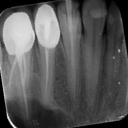

Training Epoch 9/100: 100%|██████████| 161/161 [02:13<00:00,  1.21it/s]


Epoch 9: Average Training Loss: 0.3800045559587686


Validation Epoch 9/100: 100%|██████████| 139/139 [00:41<00:00,  3.34it/s]


Epoch 9: Average Validation Loss: 0.37369299146661655



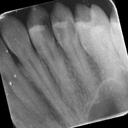
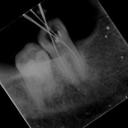
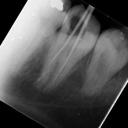
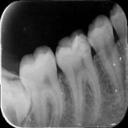
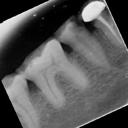
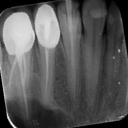

Training Epoch 10/100: 100%|██████████| 161/161 [02:13<00:00,  1.20it/s]


Epoch 10: Average Training Loss: 0.3600047207582071


Validation Epoch 10/100: 100%|██████████| 139/139 [00:41<00:00,  3.31it/s]


Epoch 10: Average Validation Loss: 0.386628801271105



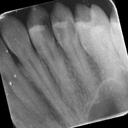
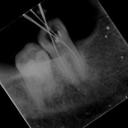
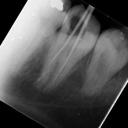
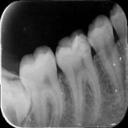
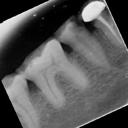
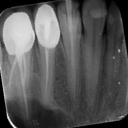

Training Epoch 11/100: 100%|██████████| 161/161 [02:13<00:00,  1.20it/s]


Epoch 11: Average Training Loss: 0.34636704369176247


Validation Epoch 11/100: 100%|██████████| 139/139 [00:42<00:00,  3.30it/s]


Epoch 11: Average Validation Loss: 0.3653061037494553



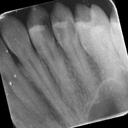
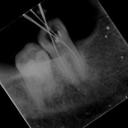
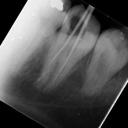
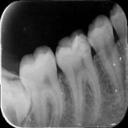
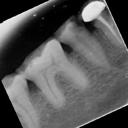
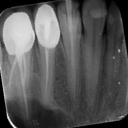

Training Epoch 12/100: 100%|██████████| 161/161 [02:13<00:00,  1.20it/s]


Epoch 12: Average Training Loss: 0.3462868166266021


Validation Epoch 12/100: 100%|██████████| 139/139 [00:42<00:00,  3.30it/s]


Epoch 12: Average Validation Loss: 0.3716243685712274



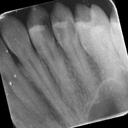
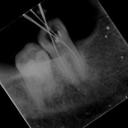
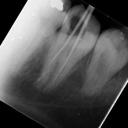
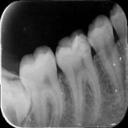
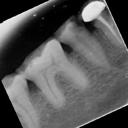
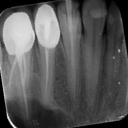

Training Epoch 13/100: 100%|██████████| 161/161 [02:13<00:00,  1.21it/s]


Epoch 13: Average Training Loss: 0.3198808173400275


Validation Epoch 13/100: 100%|██████████| 139/139 [00:41<00:00,  3.32it/s]


Epoch 13: Average Validation Loss: 0.36803230932719416



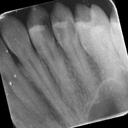
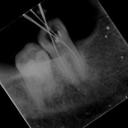
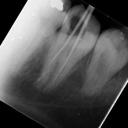
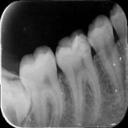
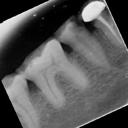
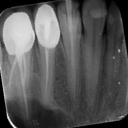

Training Epoch 14/100: 100%|██████████| 161/161 [02:13<00:00,  1.21it/s]


Epoch 14: Average Training Loss: 0.31199002016034927


Validation Epoch 14/100: 100%|██████████| 139/139 [00:41<00:00,  3.32it/s]


Epoch 14: Average Validation Loss: 0.3620056129268391



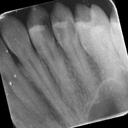
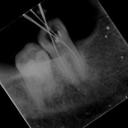
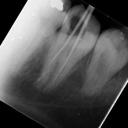
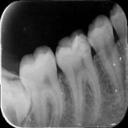
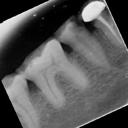
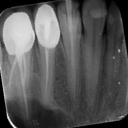

Training Epoch 15/100: 100%|██████████| 161/161 [02:13<00:00,  1.20it/s]


Epoch 15: Average Training Loss: 0.29097402438243725


Validation Epoch 15/100: 100%|██████████| 139/139 [00:41<00:00,  3.31it/s]


Epoch 15: Average Validation Loss: 0.3738183619173096



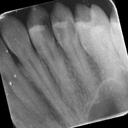
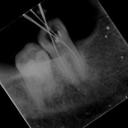
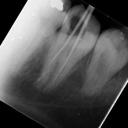
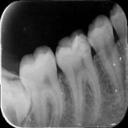
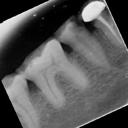
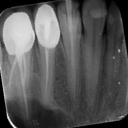

Training Epoch 16/100: 100%|██████████| 161/161 [02:13<00:00,  1.20it/s]


Epoch 16: Average Training Loss: 0.2921745696145555


Validation Epoch 16/100: 100%|██████████| 139/139 [00:41<00:00,  3.32it/s]


Epoch 16: Average Validation Loss: 0.35882233643381717



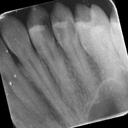
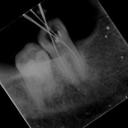
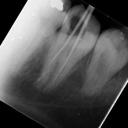
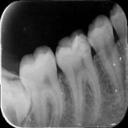
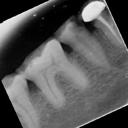
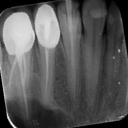

Training Epoch 17/100: 100%|██████████| 161/161 [02:13<00:00,  1.21it/s]


Epoch 17: Average Training Loss: 0.2839220945972093


Validation Epoch 17/100: 100%|██████████| 139/139 [00:41<00:00,  3.31it/s]


Epoch 17: Average Validation Loss: 0.3727205474492457



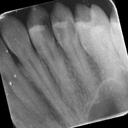
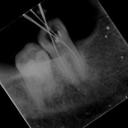
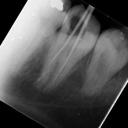
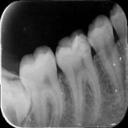
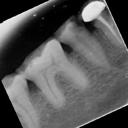
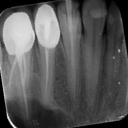

Training Epoch 18/100: 100%|██████████| 161/161 [02:13<00:00,  1.20it/s]


Epoch 18: Average Training Loss: 0.27368351782423367


Validation Epoch 18/100: 100%|██████████| 139/139 [00:42<00:00,  3.30it/s]


Epoch 18: Average Validation Loss: 0.33622020496417293



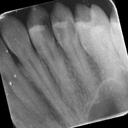
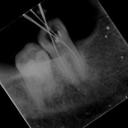
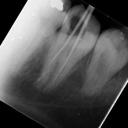
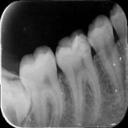
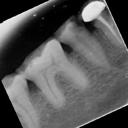
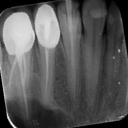

Training Epoch 19/100: 100%|██████████| 161/161 [02:14<00:00,  1.20it/s]


Epoch 19: Average Training Loss: 0.2750403005282701


Validation Epoch 19/100: 100%|██████████| 139/139 [00:41<00:00,  3.31it/s]


Epoch 19: Average Validation Loss: 0.338326542792346



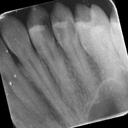
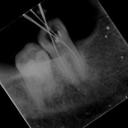
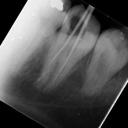
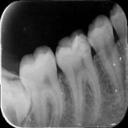
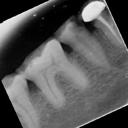
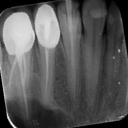

Training Epoch 20/100: 100%|██████████| 161/161 [02:13<00:00,  1.20it/s]


Epoch 20: Average Training Loss: 0.2684929360930594


Validation Epoch 20/100: 100%|██████████| 139/139 [00:41<00:00,  3.32it/s]


Epoch 20: Average Validation Loss: 0.35014319711987923



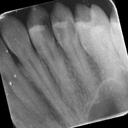
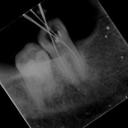
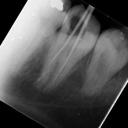
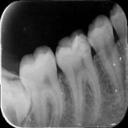
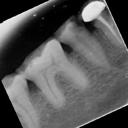
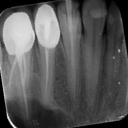

Training Epoch 21/100: 100%|██████████| 161/161 [02:13<00:00,  1.20it/s]


Epoch 21: Average Training Loss: 0.25854828333632546


Validation Epoch 21/100: 100%|██████████| 139/139 [00:41<00:00,  3.32it/s]


Epoch 21: Average Validation Loss: 0.34531692884487214



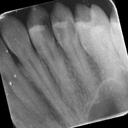
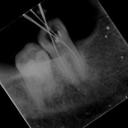
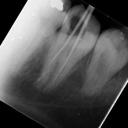
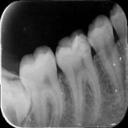
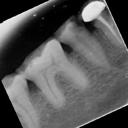
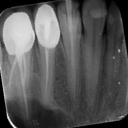

Training Epoch 22/100: 100%|██████████| 161/161 [02:13<00:00,  1.21it/s]


Epoch 22: Average Training Loss: 0.2580002741136166


Validation Epoch 22/100: 100%|██████████| 139/139 [00:41<00:00,  3.32it/s]


Epoch 22: Average Validation Loss: 0.35856173691346493



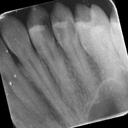
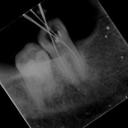
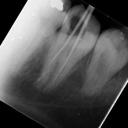
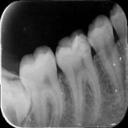
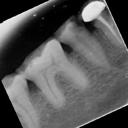
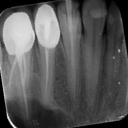

Training Epoch 23/100: 100%|██████████| 161/161 [02:13<00:00,  1.20it/s]


Epoch 23: Average Training Loss: 0.24792644409289272


Validation Epoch 23/100: 100%|██████████| 139/139 [00:41<00:00,  3.32it/s]


Epoch 23: Average Validation Loss: 0.35121041914220336



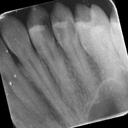
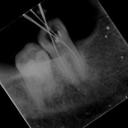
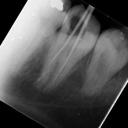
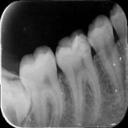
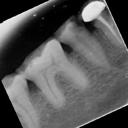
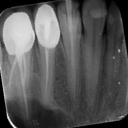

Training Epoch 24/100: 100%|██████████| 161/161 [02:13<00:00,  1.20it/s]


Epoch 24: Average Training Loss: 0.25276550710756585


Validation Epoch 24/100: 100%|██████████| 139/139 [00:41<00:00,  3.32it/s]


Epoch 24: Average Validation Loss: 0.3538970649510408



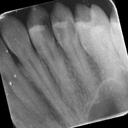
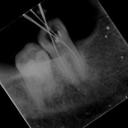
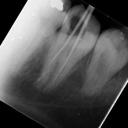
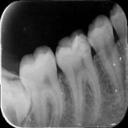
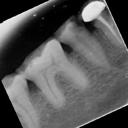
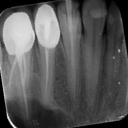

Training Epoch 25/100: 100%|██████████| 161/161 [02:13<00:00,  1.20it/s]


Epoch 25: Average Training Loss: 0.2819398596003559


Validation Epoch 25/100: 100%|██████████| 139/139 [00:41<00:00,  3.33it/s]


Epoch 25: Average Validation Loss: 0.36877281273708495



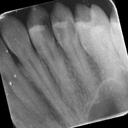
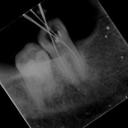
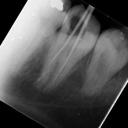
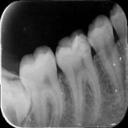
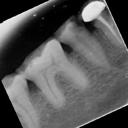
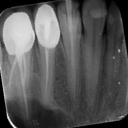

Training Epoch 26/100: 100%|██████████| 161/161 [02:13<00:00,  1.21it/s]


Epoch 26: Average Training Loss: 0.26188708184668735


Validation Epoch 26/100: 100%|██████████| 139/139 [00:41<00:00,  3.32it/s]


Epoch 26: Average Validation Loss: 0.3609574838347143



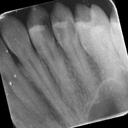
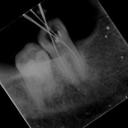
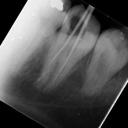
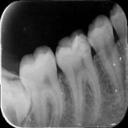
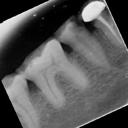
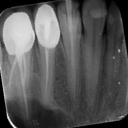

Training Epoch 27/100: 100%|██████████| 161/161 [02:13<00:00,  1.21it/s]


Epoch 27: Average Training Loss: 0.2469261537612595


Validation Epoch 27/100: 100%|██████████| 139/139 [00:41<00:00,  3.33it/s]


Epoch 27: Average Validation Loss: 0.3381023479210173



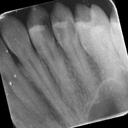
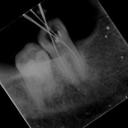
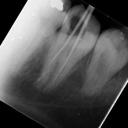
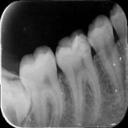
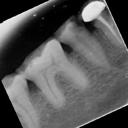
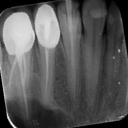

Training Epoch 28/100: 100%|██████████| 161/161 [02:13<00:00,  1.21it/s]


Epoch 28: Average Training Loss: 0.2311899830234347


Validation Epoch 28/100: 100%|██████████| 139/139 [00:41<00:00,  3.33it/s]


Epoch 28: Average Validation Loss: 0.327643524265761



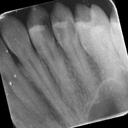
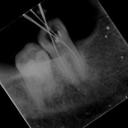
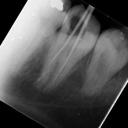
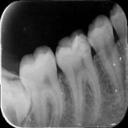
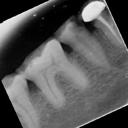
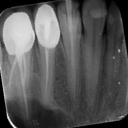

Training Epoch 29/100: 100%|██████████| 161/161 [02:13<00:00,  1.21it/s]


Epoch 29: Average Training Loss: 0.22559153168282894


Validation Epoch 29/100: 100%|██████████| 139/139 [00:41<00:00,  3.33it/s]


Epoch 29: Average Validation Loss: 0.3600500307628791



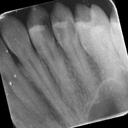
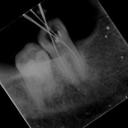
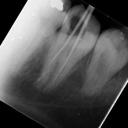
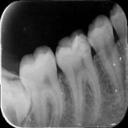
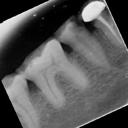
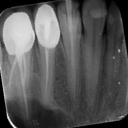

Training Epoch 30/100: 100%|██████████| 161/161 [02:13<00:00,  1.21it/s]


Epoch 30: Average Training Loss: 0.23060881015584336


Validation Epoch 30/100: 100%|██████████| 139/139 [00:41<00:00,  3.33it/s]


Epoch 30: Average Validation Loss: 0.33165661691815307



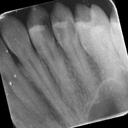
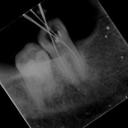
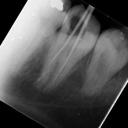
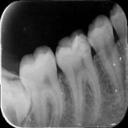
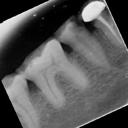
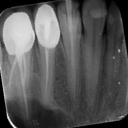

Training Epoch 31/100: 100%|██████████| 161/161 [02:13<00:00,  1.21it/s]


Epoch 31: Average Training Loss: 0.20744346517213383


Validation Epoch 31/100: 100%|██████████| 139/139 [00:41<00:00,  3.32it/s]


Epoch 31: Average Validation Loss: 0.3464501689342286



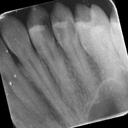
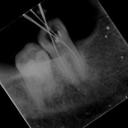
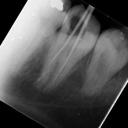
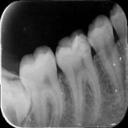
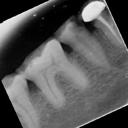
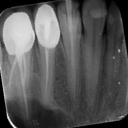

Training Epoch 32/100: 100%|██████████| 161/161 [02:13<00:00,  1.20it/s]


Epoch 32: Average Training Loss: 0.20422983856767601


Validation Epoch 32/100: 100%|██████████| 139/139 [00:41<00:00,  3.32it/s]


Epoch 32: Average Validation Loss: 0.3436759851283307



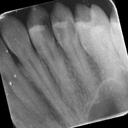
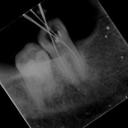
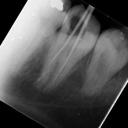
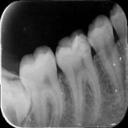
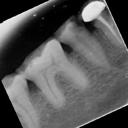
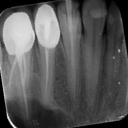

Training Epoch 33/100: 100%|██████████| 161/161 [02:13<00:00,  1.21it/s]


Epoch 33: Average Training Loss: 0.1988872416687678


Validation Epoch 33/100: 100%|██████████| 139/139 [00:41<00:00,  3.32it/s]


Epoch 33: Average Validation Loss: 0.33222221092676085



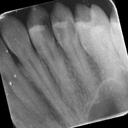
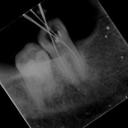
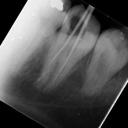
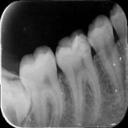
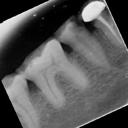
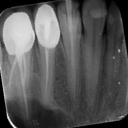

Training Epoch 34/100: 100%|██████████| 161/161 [02:13<00:00,  1.20it/s]


Epoch 34: Average Training Loss: 0.20657234613477074


Validation Epoch 34/100: 100%|██████████| 139/139 [00:42<00:00,  3.30it/s]


Epoch 34: Average Validation Loss: 0.34609135874151753



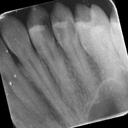
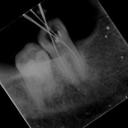
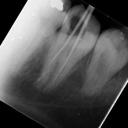
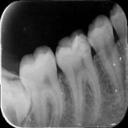
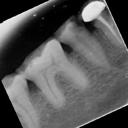
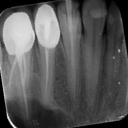

Training Epoch 35/100: 100%|██████████| 161/161 [02:13<00:00,  1.21it/s]


Epoch 35: Average Training Loss: 0.20267431683236767


Validation Epoch 35/100: 100%|██████████| 139/139 [00:42<00:00,  3.30it/s]


Epoch 35: Average Validation Loss: 0.33237788153530884



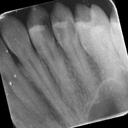
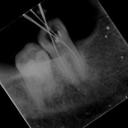
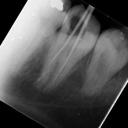
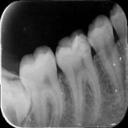
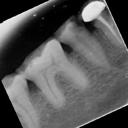
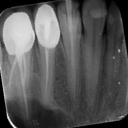

Training Epoch 36/100: 100%|██████████| 161/161 [02:13<00:00,  1.20it/s]


Epoch 36: Average Training Loss: 0.19057528290504255


Validation Epoch 36/100: 100%|██████████| 139/139 [00:41<00:00,  3.32it/s]


Epoch 36: Average Validation Loss: 0.32480096041137796



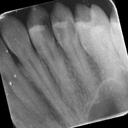
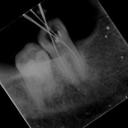
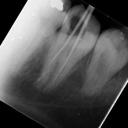
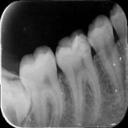
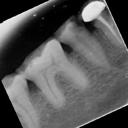
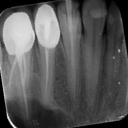

Training Epoch 37/100: 100%|██████████| 161/161 [02:13<00:00,  1.21it/s]


Epoch 37: Average Training Loss: 0.18974815329872302


Validation Epoch 37/100: 100%|██████████| 139/139 [00:41<00:00,  3.32it/s]


Epoch 37: Average Validation Loss: 0.3383875712618339



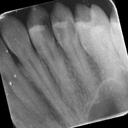
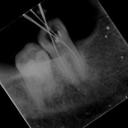
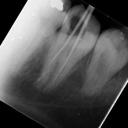
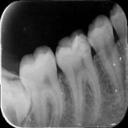
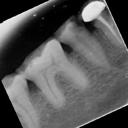
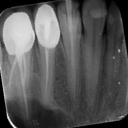

Training Epoch 38/100: 100%|██████████| 161/161 [02:13<00:00,  1.21it/s]


Epoch 38: Average Training Loss: 0.19748973089808264


Validation Epoch 38/100: 100%|██████████| 139/139 [00:41<00:00,  3.33it/s]


Epoch 38: Average Validation Loss: 0.3413866778983058



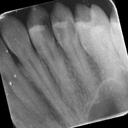
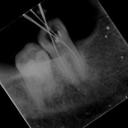
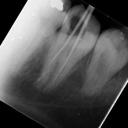
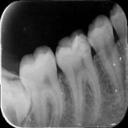
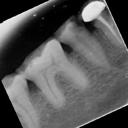
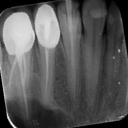

Training Epoch 39/100: 100%|██████████| 161/161 [02:13<00:00,  1.21it/s]


Epoch 39: Average Training Loss: 0.19776792694693027


Validation Epoch 39/100: 100%|██████████| 139/139 [00:41<00:00,  3.32it/s]


Epoch 39: Average Validation Loss: 0.31529098411472584



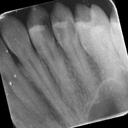
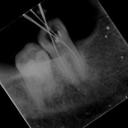
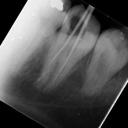
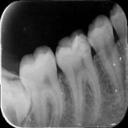
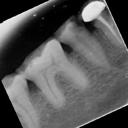
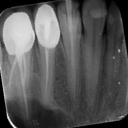

Training Epoch 40/100: 100%|██████████| 161/161 [02:13<00:00,  1.21it/s]


Epoch 40: Average Training Loss: 0.1849346933481486


Validation Epoch 40/100: 100%|██████████| 139/139 [00:41<00:00,  3.32it/s]


Epoch 40: Average Validation Loss: 0.32494025822166056



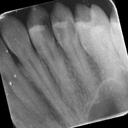
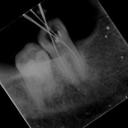
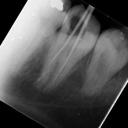
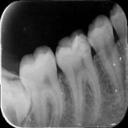
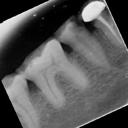
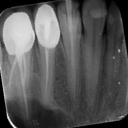

Training Epoch 41/100: 100%|██████████| 161/161 [02:13<00:00,  1.21it/s]


Epoch 41: Average Training Loss: 0.1824035184654575


Validation Epoch 41/100: 100%|██████████| 139/139 [00:41<00:00,  3.32it/s]


Epoch 41: Average Validation Loss: 0.3291926492246792



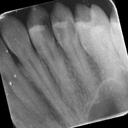
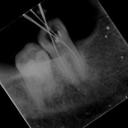
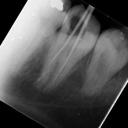
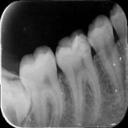
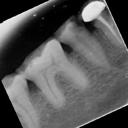
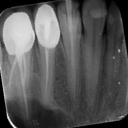

Training Epoch 42/100: 100%|██████████| 161/161 [02:13<00:00,  1.21it/s]


Epoch 42: Average Training Loss: 0.1832649474095854


Validation Epoch 42/100: 100%|██████████| 139/139 [00:41<00:00,  3.31it/s]


Epoch 42: Average Validation Loss: 0.3303297161921966



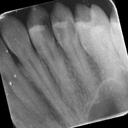
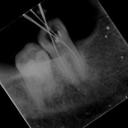
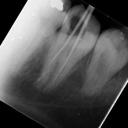
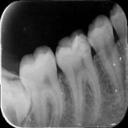
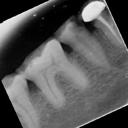
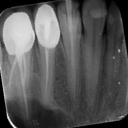

Training Epoch 43/100: 100%|██████████| 161/161 [02:13<00:00,  1.20it/s]


Epoch 43: Average Training Loss: 0.1835694496305833


Validation Epoch 43/100: 100%|██████████| 139/139 [00:41<00:00,  3.31it/s]


Epoch 43: Average Validation Loss: 0.33177157352082165



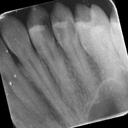
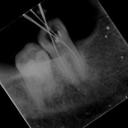
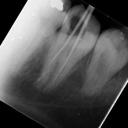
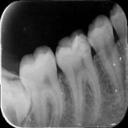
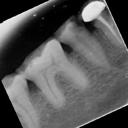
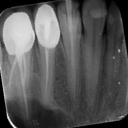

Training Epoch 44/100: 100%|██████████| 161/161 [02:13<00:00,  1.20it/s]


Epoch 44: Average Training Loss: 0.17157416783782267


Validation Epoch 44/100: 100%|██████████| 139/139 [00:44<00:00,  3.10it/s]


Epoch 44: Average Validation Loss: 0.31804528675651805



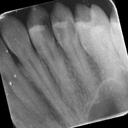
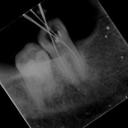
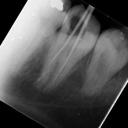
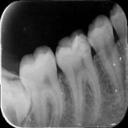
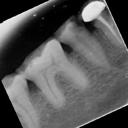
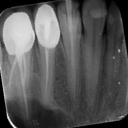

Training Epoch 45/100: 100%|██████████| 161/161 [02:13<00:00,  1.20it/s]


Epoch 45: Average Training Loss: 0.1716731507446825


Validation Epoch 45/100: 100%|██████████| 139/139 [00:41<00:00,  3.33it/s]


Epoch 45: Average Validation Loss: 0.31756590967394893



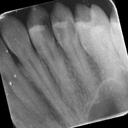
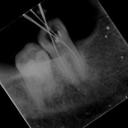
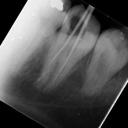
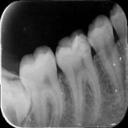
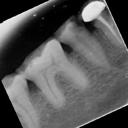
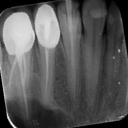

Training Epoch 46/100: 100%|██████████| 161/161 [02:13<00:00,  1.21it/s]


Epoch 46: Average Training Loss: 0.16790876960995035


Validation Epoch 46/100: 100%|██████████| 139/139 [00:41<00:00,  3.32it/s]


Epoch 46: Average Validation Loss: 0.32292180314070457



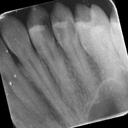
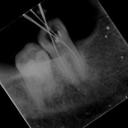
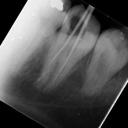
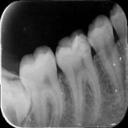
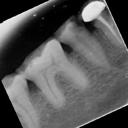
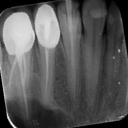

Training Epoch 47/100: 100%|██████████| 161/161 [02:13<00:00,  1.21it/s]


Epoch 47: Average Training Loss: 0.16373316906623958


Validation Epoch 47/100: 100%|██████████| 139/139 [00:41<00:00,  3.32it/s]


Epoch 47: Average Validation Loss: 0.33078866138411084



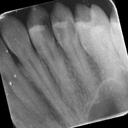
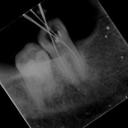
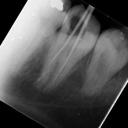
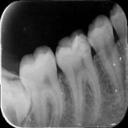
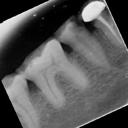
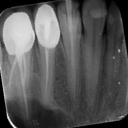

Training Epoch 48/100: 100%|██████████| 161/161 [02:13<00:00,  1.21it/s]


Epoch 48: Average Training Loss: 0.16118198498990965


Validation Epoch 48/100: 100%|██████████| 139/139 [00:41<00:00,  3.32it/s]


Epoch 48: Average Validation Loss: 0.30754983108892714



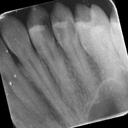
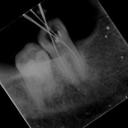
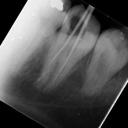
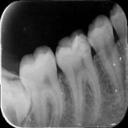
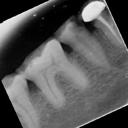
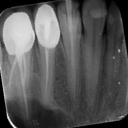

Training Epoch 49/100: 100%|██████████| 161/161 [02:13<00:00,  1.20it/s]


Epoch 49: Average Training Loss: 0.15960169784863543


Validation Epoch 49/100: 100%|██████████| 139/139 [00:41<00:00,  3.32it/s]


Epoch 49: Average Validation Loss: 0.31257207891334304



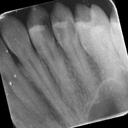
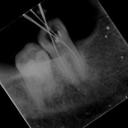
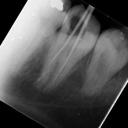
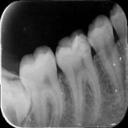
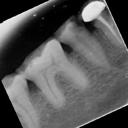
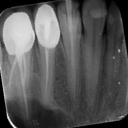

Training Epoch 50/100: 100%|██████████| 161/161 [02:13<00:00,  1.21it/s]


Epoch 50: Average Training Loss: 0.15246040665585062


Validation Epoch 50/100: 100%|██████████| 139/139 [00:42<00:00,  3.31it/s]


Epoch 50: Average Validation Loss: 0.33119367189008553



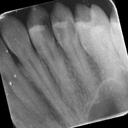
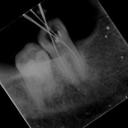
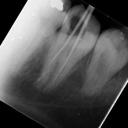
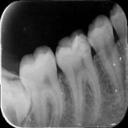
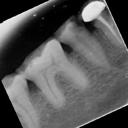
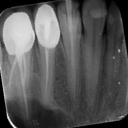

Training Epoch 51/100: 100%|██████████| 161/161 [02:13<00:00,  1.20it/s]


Epoch 51: Average Training Loss: 0.15154071855619086


Validation Epoch 51/100: 100%|██████████| 139/139 [00:42<00:00,  3.29it/s]


Epoch 51: Average Validation Loss: 0.3083112791797026



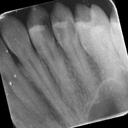
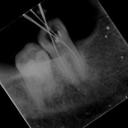
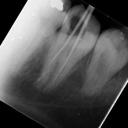
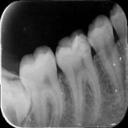
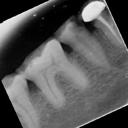
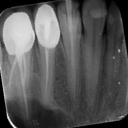

Training Epoch 52/100: 100%|██████████| 161/161 [02:14<00:00,  1.20it/s]


Epoch 52: Average Training Loss: 0.15328251096124976


Validation Epoch 52/100: 100%|██████████| 139/139 [00:41<00:00,  3.32it/s]


Epoch 52: Average Validation Loss: 0.31819094157369016



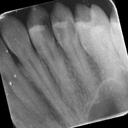
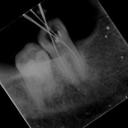
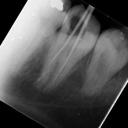
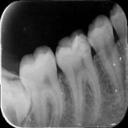
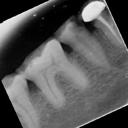
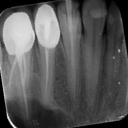

Training Epoch 53/100: 100%|██████████| 161/161 [02:13<00:00,  1.21it/s]


Epoch 53: Average Training Loss: 0.14882680847778085


Validation Epoch 53/100: 100%|██████████| 139/139 [00:41<00:00,  3.32it/s]


Epoch 53: Average Validation Loss: 0.34437070206718906



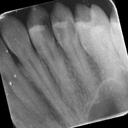
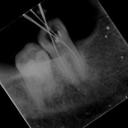
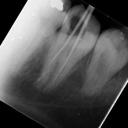
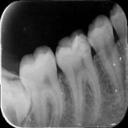
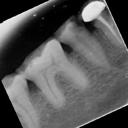
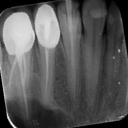

Training Epoch 54/100: 100%|██████████| 161/161 [02:13<00:00,  1.20it/s]


Epoch 54: Average Training Loss: 0.14486667097355269


Validation Epoch 54/100: 100%|██████████| 139/139 [00:41<00:00,  3.31it/s]


Epoch 54: Average Validation Loss: 0.3224349230688682



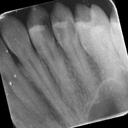
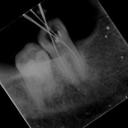
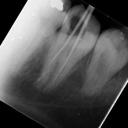
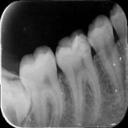
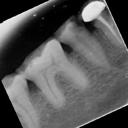
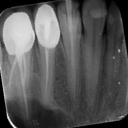

Training Epoch 55/100: 100%|██████████| 161/161 [02:13<00:00,  1.20it/s]


Epoch 55: Average Training Loss: 0.14828268579722192


Validation Epoch 55/100: 100%|██████████| 139/139 [00:41<00:00,  3.31it/s]


Epoch 55: Average Validation Loss: 0.3388091489511857



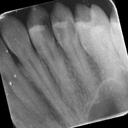
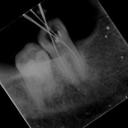
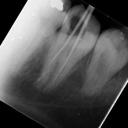
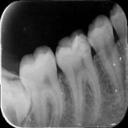
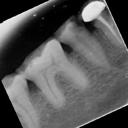
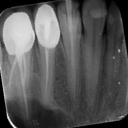

Training Epoch 56/100: 100%|██████████| 161/161 [02:14<00:00,  1.20it/s]


Epoch 56: Average Training Loss: 0.20097763102894983


Validation Epoch 56/100: 100%|██████████| 139/139 [00:42<00:00,  3.29it/s]


Epoch 56: Average Validation Loss: 0.3336302295139582



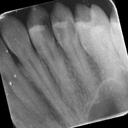
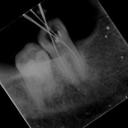
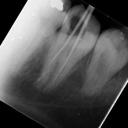
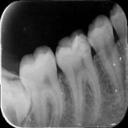
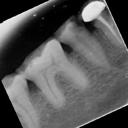
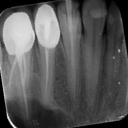

Training Epoch 57/100: 100%|██████████| 161/161 [02:13<00:00,  1.21it/s]


Epoch 57: Average Training Loss: 0.15150184563783384


Validation Epoch 57/100: 100%|██████████| 139/139 [00:41<00:00,  3.32it/s]


Epoch 57: Average Validation Loss: 0.31632779396587996



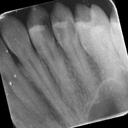
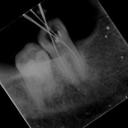
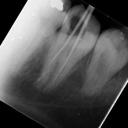
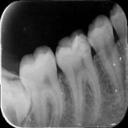
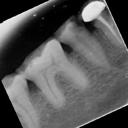
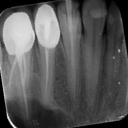

Training Epoch 58/100: 100%|██████████| 161/161 [02:13<00:00,  1.21it/s]


Epoch 58: Average Training Loss: 0.14830165839991213


Validation Epoch 58/100: 100%|██████████| 139/139 [00:41<00:00,  3.32it/s]


Epoch 58: Average Validation Loss: 0.31395650208800385



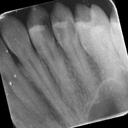
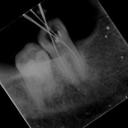
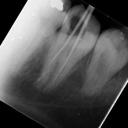
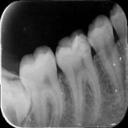
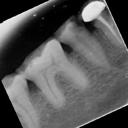
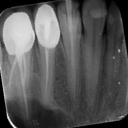

Training Epoch 59/100: 100%|██████████| 161/161 [02:13<00:00,  1.20it/s]


Epoch 59: Average Training Loss: 0.19614943211770947


Validation Epoch 59/100: 100%|██████████| 139/139 [00:42<00:00,  3.28it/s]


Epoch 59: Average Validation Loss: 0.3354665816446646



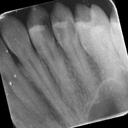
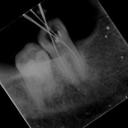
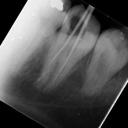
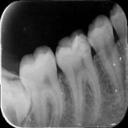
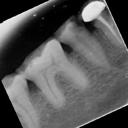
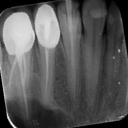

Training Epoch 60/100: 100%|██████████| 161/161 [02:13<00:00,  1.20it/s]


Epoch 60: Average Training Loss: 0.15880118870401974


Validation Epoch 60/100: 100%|██████████| 139/139 [00:41<00:00,  3.31it/s]


Epoch 60: Average Validation Loss: 0.31556102373509953



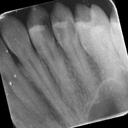
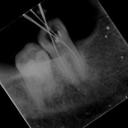
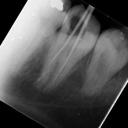
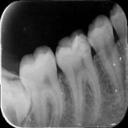
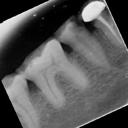
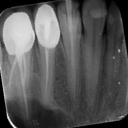

Training Epoch 61/100: 100%|██████████| 161/161 [02:13<00:00,  1.20it/s]


Epoch 61: Average Training Loss: 0.14488240780297273


Validation Epoch 61/100: 100%|██████████| 139/139 [00:42<00:00,  3.31it/s]


Epoch 61: Average Validation Loss: 0.31901653574632227



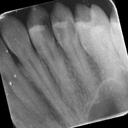
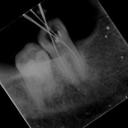
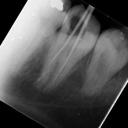
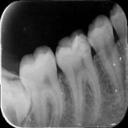
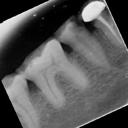
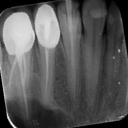

Training Epoch 62/100: 100%|██████████| 161/161 [02:13<00:00,  1.20it/s]


Epoch 62: Average Training Loss: 0.13966884878203736


Validation Epoch 62/100: 100%|██████████| 139/139 [00:42<00:00,  3.31it/s]


Epoch 62: Average Validation Loss: 0.32052816717262317



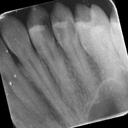
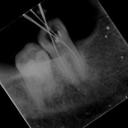
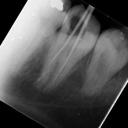
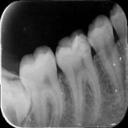
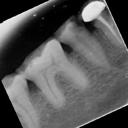
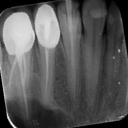

Training Epoch 63/100: 100%|██████████| 161/161 [02:13<00:00,  1.21it/s]


Epoch 63: Average Training Loss: 0.13329993806177784


Validation Epoch 63/100: 100%|██████████| 139/139 [00:41<00:00,  3.31it/s]


Epoch 63: Average Validation Loss: 0.3088691686983589



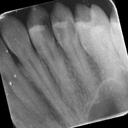
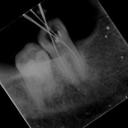
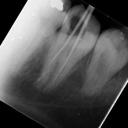
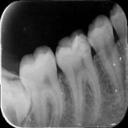
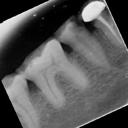
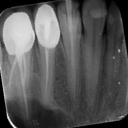

Training Epoch 64/100: 100%|██████████| 161/161 [02:13<00:00,  1.20it/s]


Epoch 64: Average Training Loss: 0.13454342693645763


Validation Epoch 64/100: 100%|██████████| 139/139 [00:42<00:00,  3.30it/s]


Epoch 64: Average Validation Loss: 0.31950806347961475



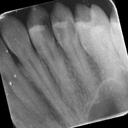
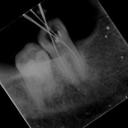
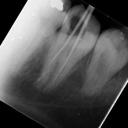
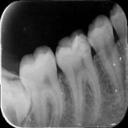
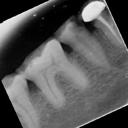
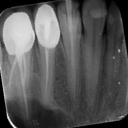

Training Epoch 65/100: 100%|██████████| 161/161 [02:13<00:00,  1.20it/s]


Epoch 65: Average Training Loss: 0.13090002141106202


Validation Epoch 65/100: 100%|██████████| 139/139 [00:41<00:00,  3.31it/s]


Epoch 65: Average Validation Loss: 0.3155291208179949



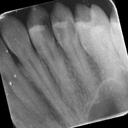
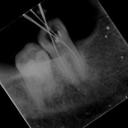
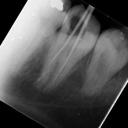
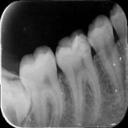
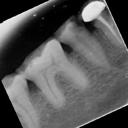
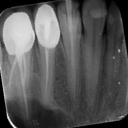

Training Epoch 66/100: 100%|██████████| 161/161 [02:13<00:00,  1.20it/s]


Epoch 66: Average Training Loss: 0.11924949150694453


Validation Epoch 66/100: 100%|██████████| 139/139 [00:41<00:00,  3.32it/s]


Epoch 66: Average Validation Loss: 0.3190074810262421



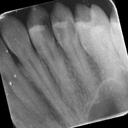
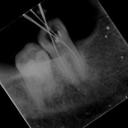
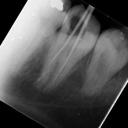
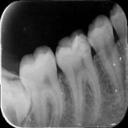
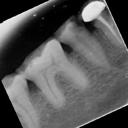
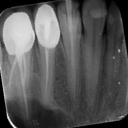

Training Epoch 67/100: 100%|██████████| 161/161 [02:13<00:00,  1.20it/s]


Epoch 67: Average Training Loss: 0.11767337047813102


Validation Epoch 67/100: 100%|██████████| 139/139 [00:42<00:00,  3.30it/s]


Epoch 67: Average Validation Loss: 0.3200995695221124



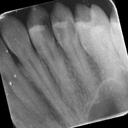
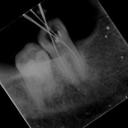
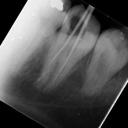
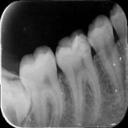
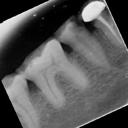
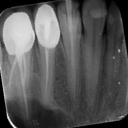

Training Epoch 68/100: 100%|██████████| 161/161 [02:14<00:00,  1.20it/s]


Epoch 68: Average Training Loss: 0.12148022760423074


Validation Epoch 68/100: 100%|██████████| 139/139 [00:42<00:00,  3.31it/s]


Epoch 68: Average Validation Loss: 0.30857715124545765



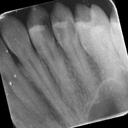
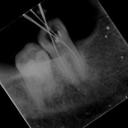
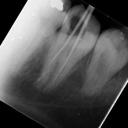
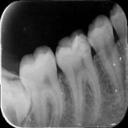
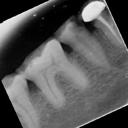
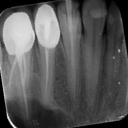

Training Epoch 69/100: 100%|██████████| 161/161 [02:13<00:00,  1.20it/s]


Epoch 69: Average Training Loss: 0.12051323322313172


Validation Epoch 69/100: 100%|██████████| 139/139 [00:41<00:00,  3.31it/s]


Epoch 69: Average Validation Loss: 0.3130411027039555



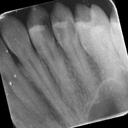
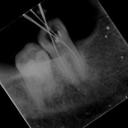
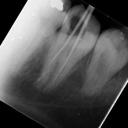
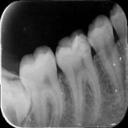
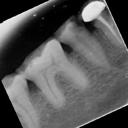
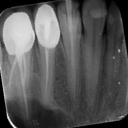

Training Epoch 70/100: 100%|██████████| 161/161 [02:13<00:00,  1.20it/s]


Epoch 70: Average Training Loss: 0.11716851691559235


Validation Epoch 70/100: 100%|██████████| 139/139 [00:42<00:00,  3.31it/s]


Epoch 70: Average Validation Loss: 0.31269018350691674



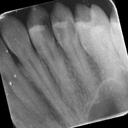
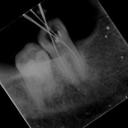
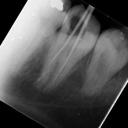
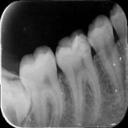
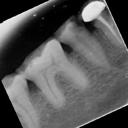
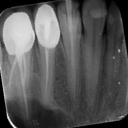

Training Epoch 71/100: 100%|██████████| 161/161 [02:13<00:00,  1.21it/s]


Epoch 71: Average Training Loss: 0.1143697825324091


Validation Epoch 71/100: 100%|██████████| 139/139 [00:41<00:00,  3.32it/s]


Epoch 71: Average Validation Loss: 0.3216757523766953



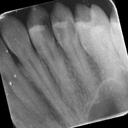
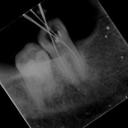
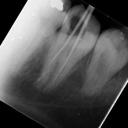
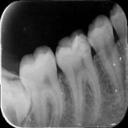
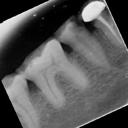
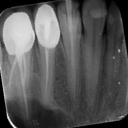

Training Epoch 72/100: 100%|██████████| 161/161 [02:13<00:00,  1.21it/s]


Epoch 72: Average Training Loss: 0.11312520746951518


Validation Epoch 72/100: 100%|██████████| 139/139 [00:41<00:00,  3.32it/s]


Epoch 72: Average Validation Loss: 0.317218426829405



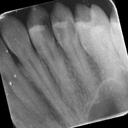
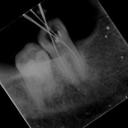
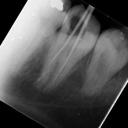
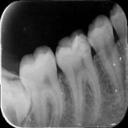
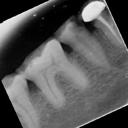
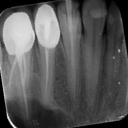

Training Epoch 73/100: 100%|██████████| 161/161 [02:13<00:00,  1.21it/s]


Epoch 73: Average Training Loss: 0.11305008583372424


Validation Epoch 73/100: 100%|██████████| 139/139 [00:42<00:00,  3.31it/s]


Epoch 73: Average Validation Loss: 0.30280595489864726



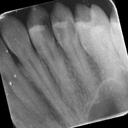
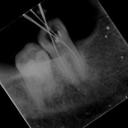
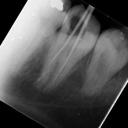
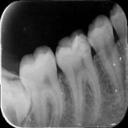
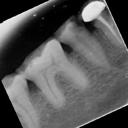
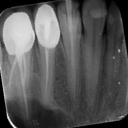

Training Epoch 74/100: 100%|██████████| 161/161 [02:13<00:00,  1.21it/s]


Epoch 74: Average Training Loss: 0.1078756806550559


Validation Epoch 74/100: 100%|██████████| 139/139 [00:41<00:00,  3.31it/s]


Epoch 74: Average Validation Loss: 0.31380184300297453



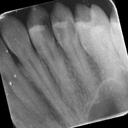
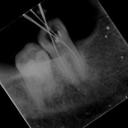
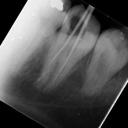
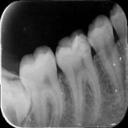
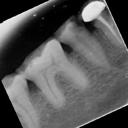
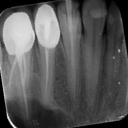

Training Epoch 75/100: 100%|██████████| 161/161 [02:13<00:00,  1.21it/s]


Epoch 75: Average Training Loss: 0.10924009466254563


Validation Epoch 75/100: 100%|██████████| 139/139 [00:41<00:00,  3.32it/s]


Epoch 75: Average Validation Loss: 0.3157755585534753



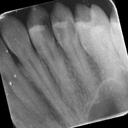
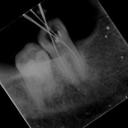
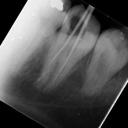
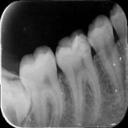
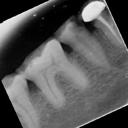
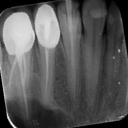

Training Epoch 76/100: 100%|██████████| 161/161 [02:13<00:00,  1.21it/s]


Epoch 76: Average Training Loss: 0.10859540877690227


Validation Epoch 76/100: 100%|██████████| 139/139 [00:41<00:00,  3.32it/s]


Epoch 76: Average Validation Loss: 0.3089718623957831



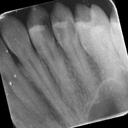
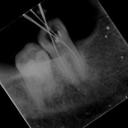
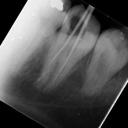
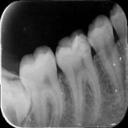
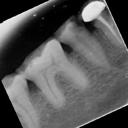
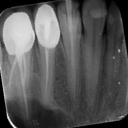

Training Epoch 77/100: 100%|██████████| 161/161 [02:13<00:00,  1.21it/s]


Epoch 77: Average Training Loss: 0.12379186173542316


Validation Epoch 77/100: 100%|██████████| 139/139 [00:42<00:00,  3.30it/s]


Epoch 77: Average Validation Loss: 0.318307616098



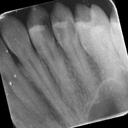
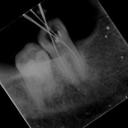
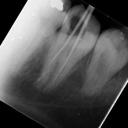
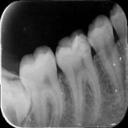
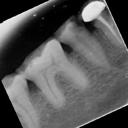
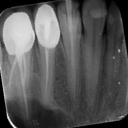

Training Epoch 78/100: 100%|██████████| 161/161 [02:13<00:00,  1.21it/s]


Epoch 78: Average Training Loss: 0.10336998489147388


Validation Epoch 78/100: 100%|██████████| 139/139 [00:41<00:00,  3.33it/s]


Epoch 78: Average Validation Loss: 0.30938521292891435



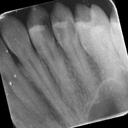
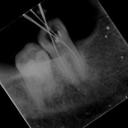
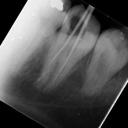
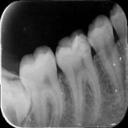
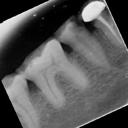
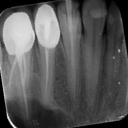

Training Epoch 79/100: 100%|██████████| 161/161 [02:13<00:00,  1.20it/s]


Epoch 79: Average Training Loss: 0.10167969821125084


Validation Epoch 79/100: 100%|██████████| 139/139 [00:41<00:00,  3.32it/s]


Epoch 79: Average Validation Loss: 0.3100341387468276



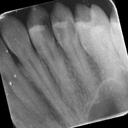
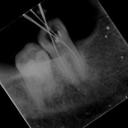
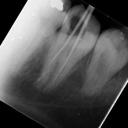
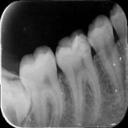
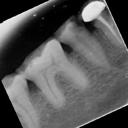
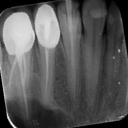

Training Epoch 80/100: 100%|██████████| 161/161 [02:13<00:00,  1.21it/s]


Epoch 80: Average Training Loss: 0.10114885547331401


Validation Epoch 80/100: 100%|██████████| 139/139 [00:41<00:00,  3.31it/s]


Epoch 80: Average Validation Loss: 0.31374450523754677



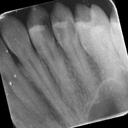
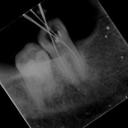
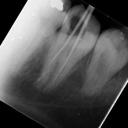
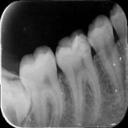
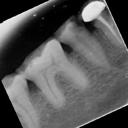
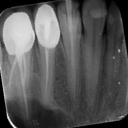

Training Epoch 81/100: 100%|██████████| 161/161 [02:13<00:00,  1.21it/s]


Epoch 81: Average Training Loss: 0.10137900385010687


Validation Epoch 81/100: 100%|██████████| 139/139 [00:41<00:00,  3.32it/s]


Epoch 81: Average Validation Loss: 0.31472768910604415



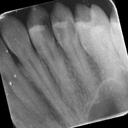
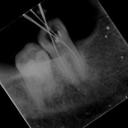
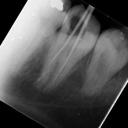
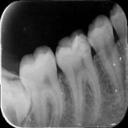
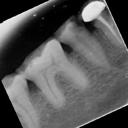
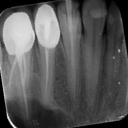

Training Epoch 82/100: 100%|██████████| 161/161 [02:13<00:00,  1.21it/s]


Epoch 82: Average Training Loss: 0.1017513726346241


Validation Epoch 82/100: 100%|██████████| 139/139 [00:41<00:00,  3.32it/s]


Epoch 82: Average Validation Loss: 0.31473068888935685



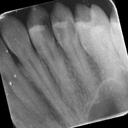
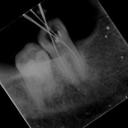
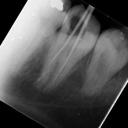
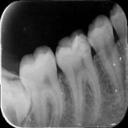
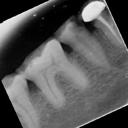
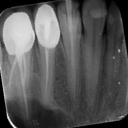

Training Epoch 83/100: 100%|██████████| 161/161 [02:13<00:00,  1.20it/s]


Epoch 83: Average Training Loss: 0.09995496246431555


Validation Epoch 83/100: 100%|██████████| 139/139 [00:42<00:00,  3.29it/s]


Epoch 83: Average Validation Loss: 0.3096311559110022



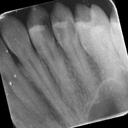
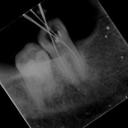
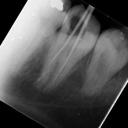
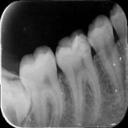
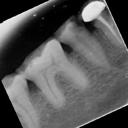
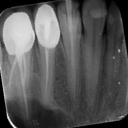

Training Epoch 84/100: 100%|██████████| 161/161 [02:13<00:00,  1.21it/s]


Epoch 84: Average Training Loss: 0.09584843005221452


Validation Epoch 84/100: 100%|██████████| 139/139 [00:41<00:00,  3.32it/s]


Epoch 84: Average Validation Loss: 0.3118203132942641



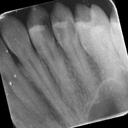
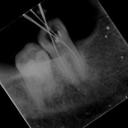
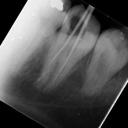
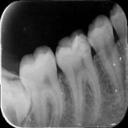
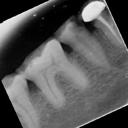
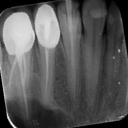

Training Epoch 85/100: 100%|██████████| 161/161 [02:13<00:00,  1.21it/s]


Epoch 85: Average Training Loss: 0.09481408315138047


Validation Epoch 85/100: 100%|██████████| 139/139 [00:41<00:00,  3.32it/s]


Epoch 85: Average Validation Loss: 0.31242051803701215



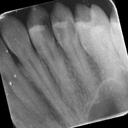
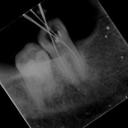
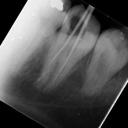
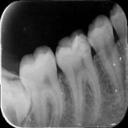
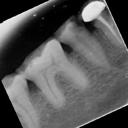
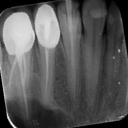

Training Epoch 86/100: 100%|██████████| 161/161 [02:13<00:00,  1.21it/s]


Epoch 86: Average Training Loss: 0.09672003544820762


Validation Epoch 86/100: 100%|██████████| 139/139 [00:41<00:00,  3.32it/s]


Epoch 86: Average Validation Loss: 0.3120306861191559



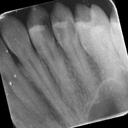
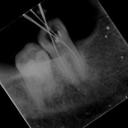
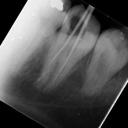
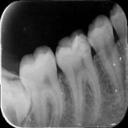
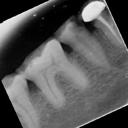
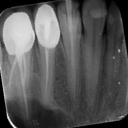

Training Epoch 87/100: 100%|██████████| 161/161 [02:13<00:00,  1.20it/s]


Epoch 87: Average Training Loss: 0.0945021014151551


Validation Epoch 87/100: 100%|██████████| 139/139 [00:41<00:00,  3.31it/s]


Epoch 87: Average Validation Loss: 0.3094550395826642



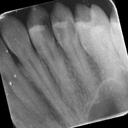
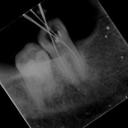
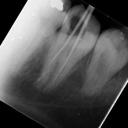
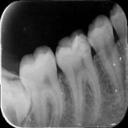
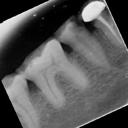
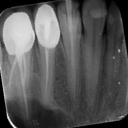

Training Epoch 88/100: 100%|██████████| 161/161 [02:13<00:00,  1.21it/s]


Epoch 88: Average Training Loss: 0.09026417157016926


Validation Epoch 88/100: 100%|██████████| 139/139 [00:41<00:00,  3.31it/s]


Epoch 88: Average Validation Loss: 0.3113541447108598



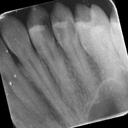
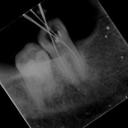
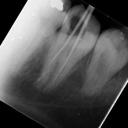
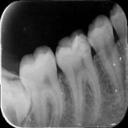
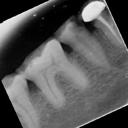
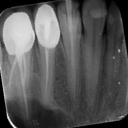

Training Epoch 89/100: 100%|██████████| 161/161 [02:13<00:00,  1.21it/s]


Epoch 89: Average Training Loss: 0.1072484573569172


Validation Epoch 89/100: 100%|██████████| 139/139 [00:41<00:00,  3.31it/s]


Epoch 89: Average Validation Loss: 0.3196435466864341



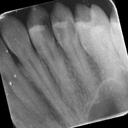
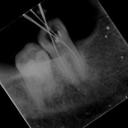
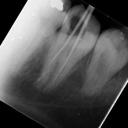
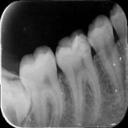
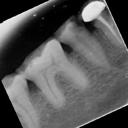
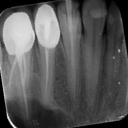

Training Epoch 90/100: 100%|██████████| 161/161 [02:13<00:00,  1.20it/s]


Epoch 90: Average Training Loss: 0.09018722136059533


Validation Epoch 90/100: 100%|██████████| 139/139 [00:41<00:00,  3.32it/s]


Epoch 90: Average Validation Loss: 0.3120450488820994



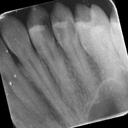
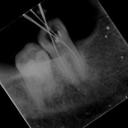
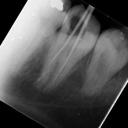
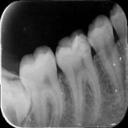
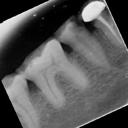
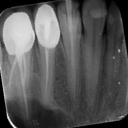

Training Epoch 91/100: 100%|██████████| 161/161 [02:13<00:00,  1.20it/s]


Epoch 91: Average Training Loss: 0.08685513738519657


Validation Epoch 91/100: 100%|██████████| 139/139 [00:42<00:00,  3.30it/s]


Epoch 91: Average Validation Loss: 0.3120828249739657



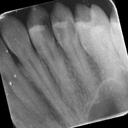
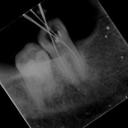
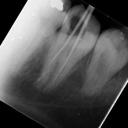
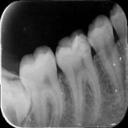
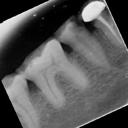
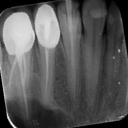

Training Epoch 92/100: 100%|██████████| 161/161 [02:13<00:00,  1.21it/s]


Epoch 92: Average Training Loss: 0.08807180845034049


Validation Epoch 92/100: 100%|██████████| 139/139 [00:41<00:00,  3.32it/s]


Epoch 92: Average Validation Loss: 0.31286443814152864



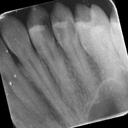
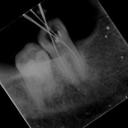
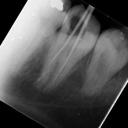
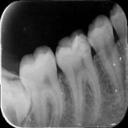
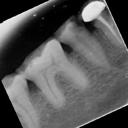
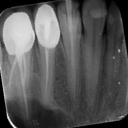

Training Epoch 93/100: 100%|██████████| 161/161 [02:13<00:00,  1.21it/s]


Epoch 93: Average Training Loss: 0.08714487650055693


Validation Epoch 93/100: 100%|██████████| 139/139 [00:41<00:00,  3.32it/s]


Epoch 93: Average Validation Loss: 0.3135941588460541



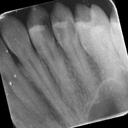
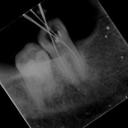
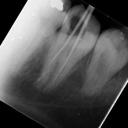
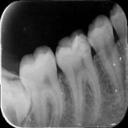
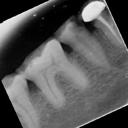
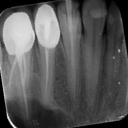

Training Epoch 94/100: 100%|██████████| 161/161 [02:13<00:00,  1.21it/s]


Epoch 94: Average Training Loss: 0.10345985764718574


Validation Epoch 94/100: 100%|██████████| 139/139 [00:41<00:00,  3.32it/s]


Epoch 94: Average Validation Loss: 0.3111587666752313



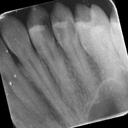
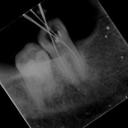
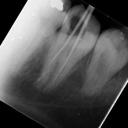
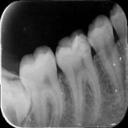
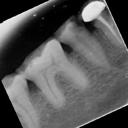
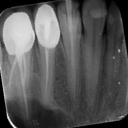

Training Epoch 95/100: 100%|██████████| 161/161 [02:13<00:00,  1.21it/s]


Epoch 95: Average Training Loss: 0.0868119937223122


Validation Epoch 95/100: 100%|██████████| 139/139 [00:41<00:00,  3.32it/s]


Epoch 95: Average Validation Loss: 0.3145123786098665



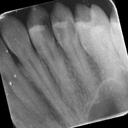
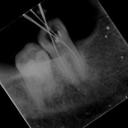
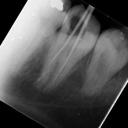
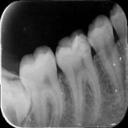
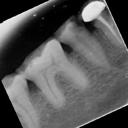
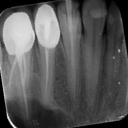

Training Epoch 96/100: 100%|██████████| 161/161 [02:13<00:00,  1.21it/s]


Epoch 96: Average Training Loss: 0.0845920636856593


Validation Epoch 96/100: 100%|██████████| 139/139 [00:41<00:00,  3.32it/s]


Epoch 96: Average Validation Loss: 0.3139505283036035



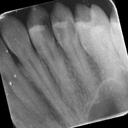
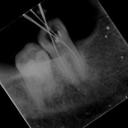
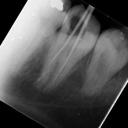
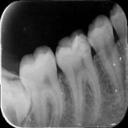
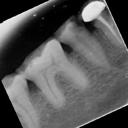
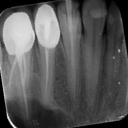

Training Epoch 97/100: 100%|██████████| 161/161 [02:13<00:00,  1.20it/s]


Epoch 97: Average Training Loss: 0.08205334049713167


Validation Epoch 97/100: 100%|██████████| 139/139 [00:42<00:00,  3.30it/s]


Epoch 97: Average Validation Loss: 0.31307378618998066



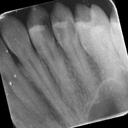
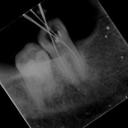
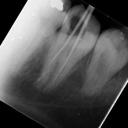
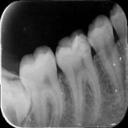
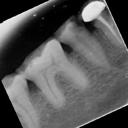
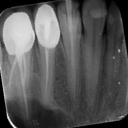

Training Epoch 98/100: 100%|██████████| 161/161 [02:13<00:00,  1.21it/s]


Epoch 98: Average Training Loss: 0.08249004343698113


Validation Epoch 98/100: 100%|██████████| 139/139 [00:41<00:00,  3.31it/s]


Epoch 98: Average Validation Loss: 0.3145610545393374



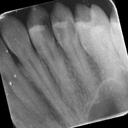
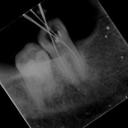
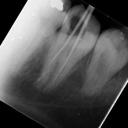
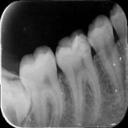
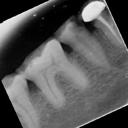
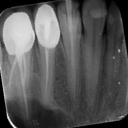

Training Epoch 99/100: 100%|██████████| 161/161 [02:13<00:00,  1.21it/s]


Epoch 99: Average Training Loss: 0.0824933200958908


Validation Epoch 99/100: 100%|██████████| 139/139 [00:41<00:00,  3.32it/s]


Epoch 99: Average Validation Loss: 0.3136600822799926



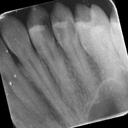
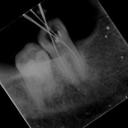
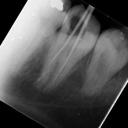
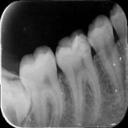
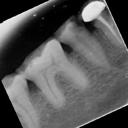
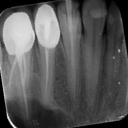

Training Epoch 100/100: 100%|██████████| 161/161 [02:13<00:00,  1.21it/s]


Epoch 100: Average Training Loss: 0.08146031770091619


Validation Epoch 100/100: 100%|██████████| 139/139 [00:41<00:00,  3.32it/s]


Epoch 100: Average Validation Loss: 0.3138082114135404



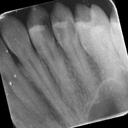
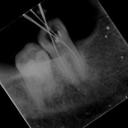
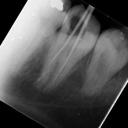
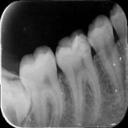
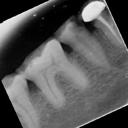
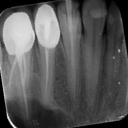

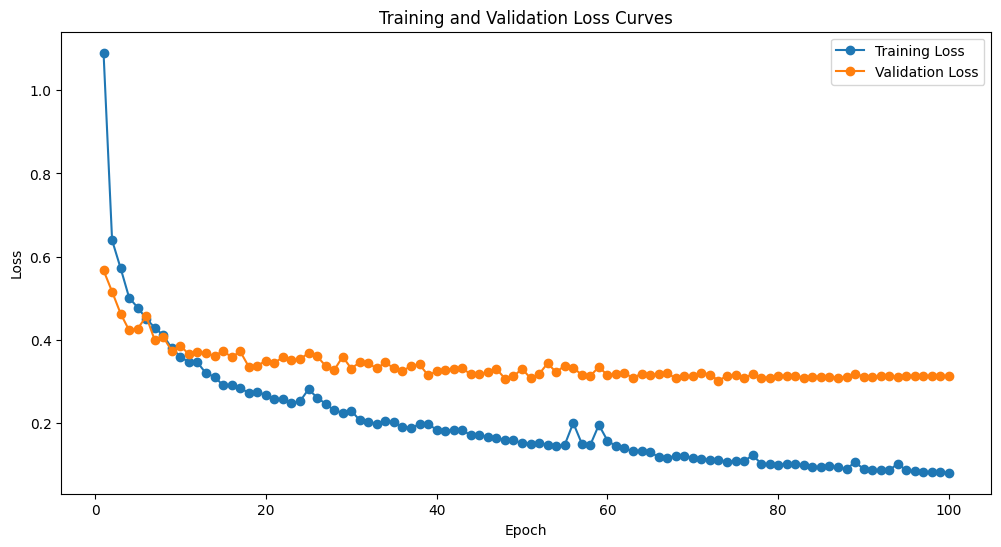

In [14]:
# Example usage

train_model(train_loader, val_loader, peft_model, processor, epochs=100, lr=1e-3)

In [15]:
"""import os

import torch

from transformers import AutoProcessor



# Specify the directory where the best model and processor were saved

output_dir = "/kaggle/working/model_checkpoints/best_model_epoch_3"



# Check if the directory exists

if not os.path.exists(output_dir):

    raise FileNotFoundError(f"The directory {output_dir} does not exist. Please check the path.")



# Reload the best model state dict

model = peft_model  # Ensure to define or import the correct model architecture used during training

model_path = os.path.join(output_dir, "model.pth")

model.load_state_dict(torch.load(model_path))

model.to(DEVICE)

model.eval()  # Set the model to evaluation mode





print(f"Successfully reloaded the best model and processor from best epoch.")

"""

'import os\n\nimport torch\n\nfrom transformers import AutoProcessor\n\n\n\n# Specify the directory where the best model and processor were saved\n\noutput_dir = "/kaggle/working/model_checkpoints/best_model_epoch_3"\n\n\n\n# Check if the directory exists\n\nif not os.path.exists(output_dir):\n\n    raise FileNotFoundError(f"The directory {output_dir} does not exist. Please check the path.")\n\n\n\n# Reload the best model state dict\n\nmodel = peft_model  # Ensure to define or import the correct model architecture used during training\n\nmodel_path = os.path.join(output_dir, "model.pth")\n\nmodel.load_state_dict(torch.load(model_path))\n\nmodel.to(DEVICE)\n\nmodel.eval()  # Set the model to evaluation mode\n\n\n\n\n\nprint(f"Successfully reloaded the best model and processor from best epoch.")\n\n'


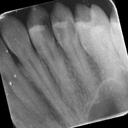
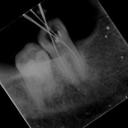
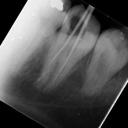
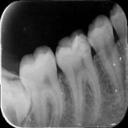
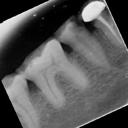
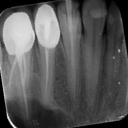
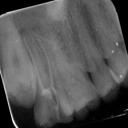
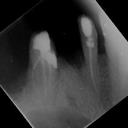
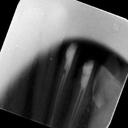
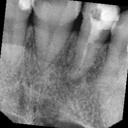
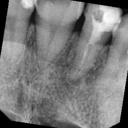
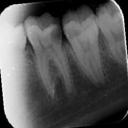
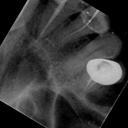
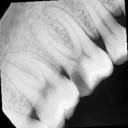
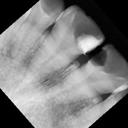
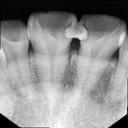
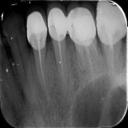
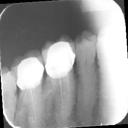
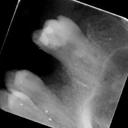
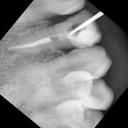
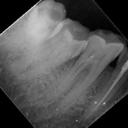
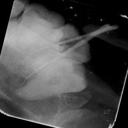
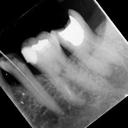
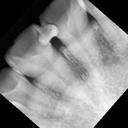
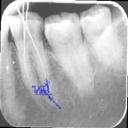
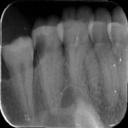
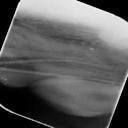
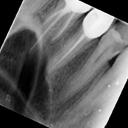
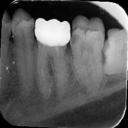
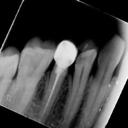
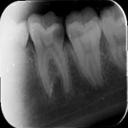
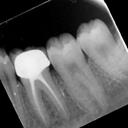
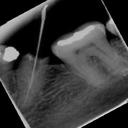
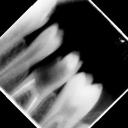
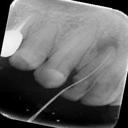
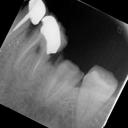
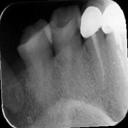
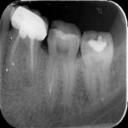
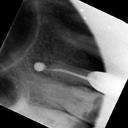
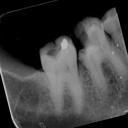
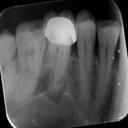
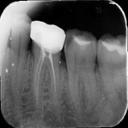
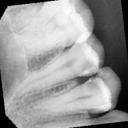
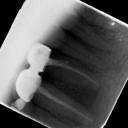
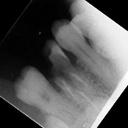
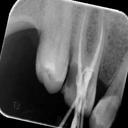
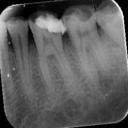
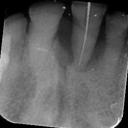
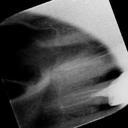
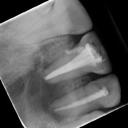
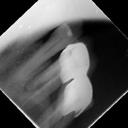
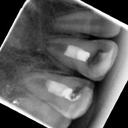
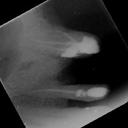
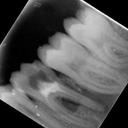
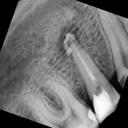
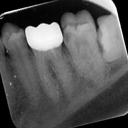
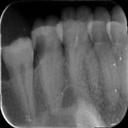
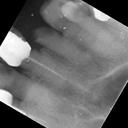
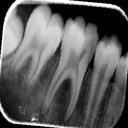
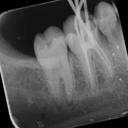
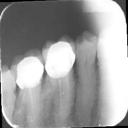
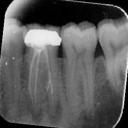
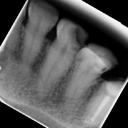
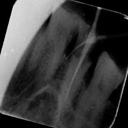
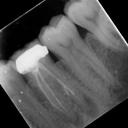
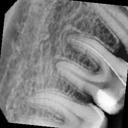
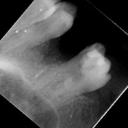
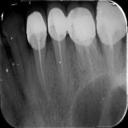
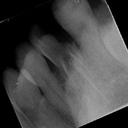
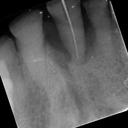
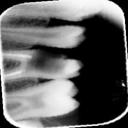
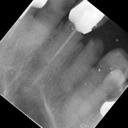
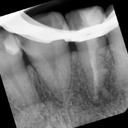
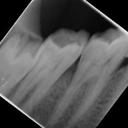
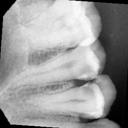
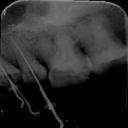
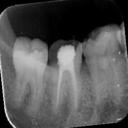
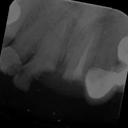
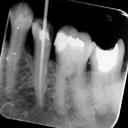
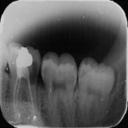
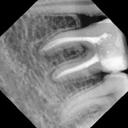
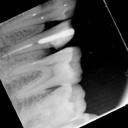
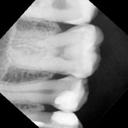
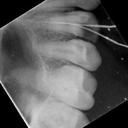
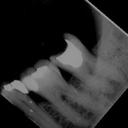
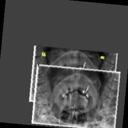
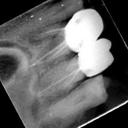
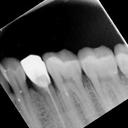
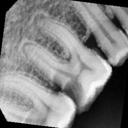
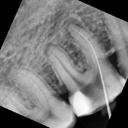
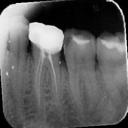
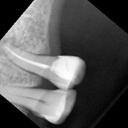
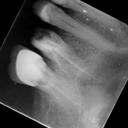
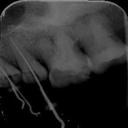
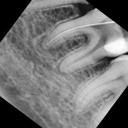
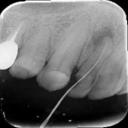
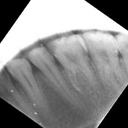
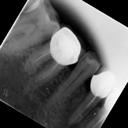
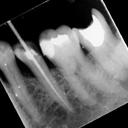
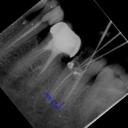
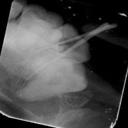
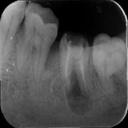
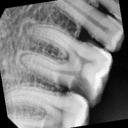
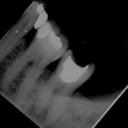
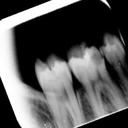
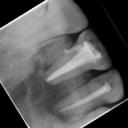
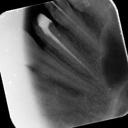
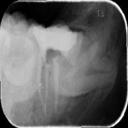
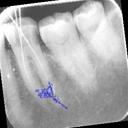
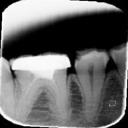
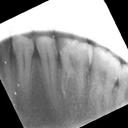
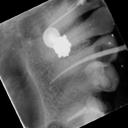
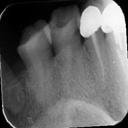
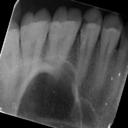
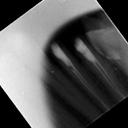
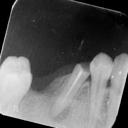
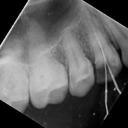
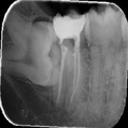
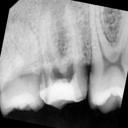
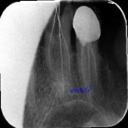
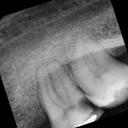
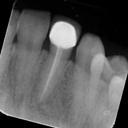
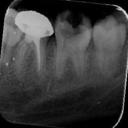
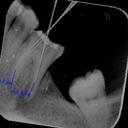
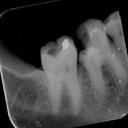
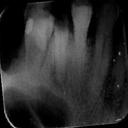
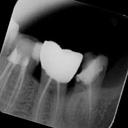
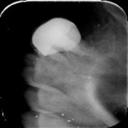
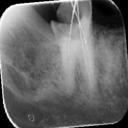
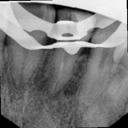
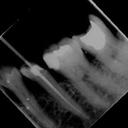
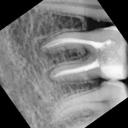
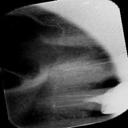
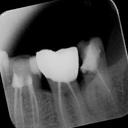
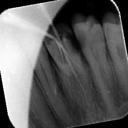
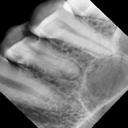
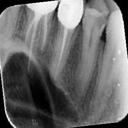
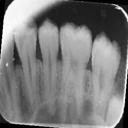
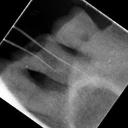

In [16]:
# Render inference results for validation data

render_inference_results(peft_model, val_loader.dataset, 139)

Inference: 100%|██████████| 139/139 [04:44<00:00,  2.05s/it]


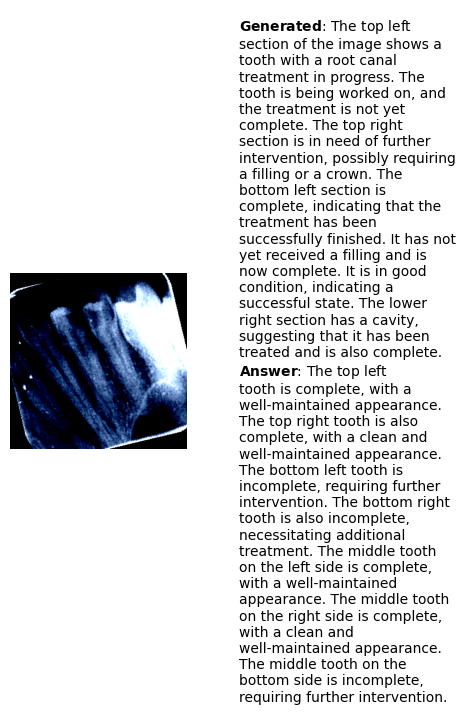

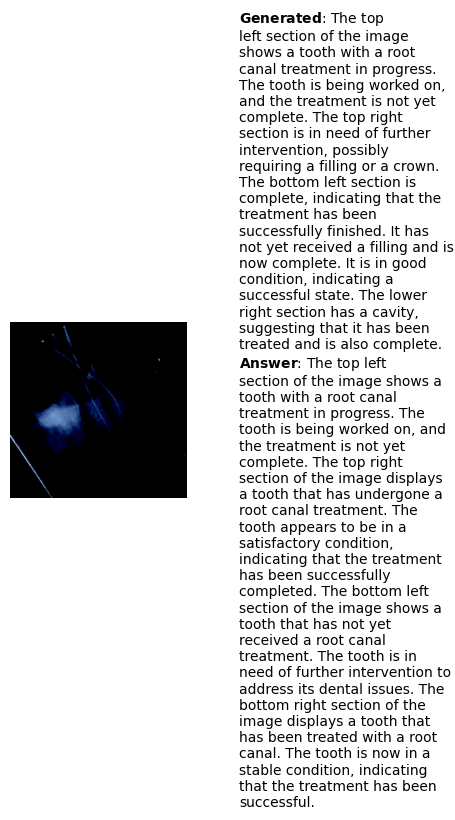

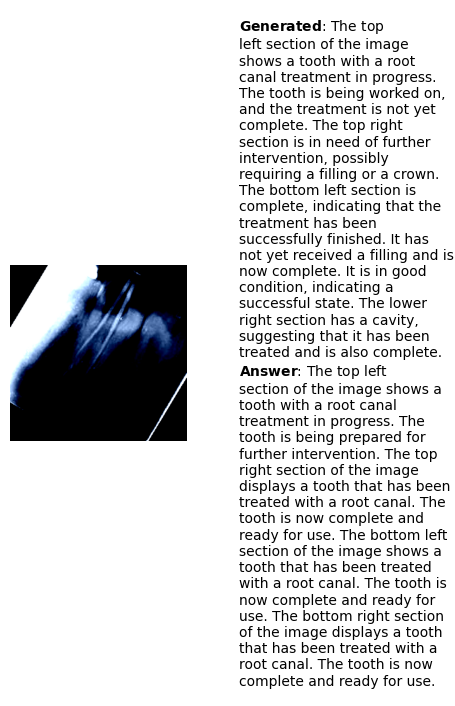

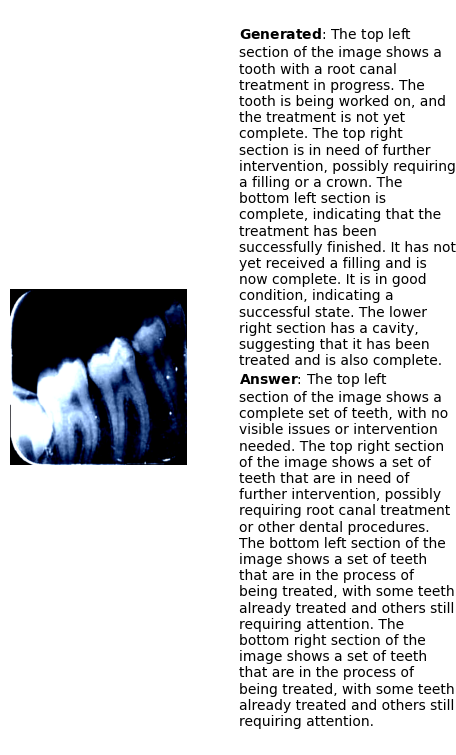

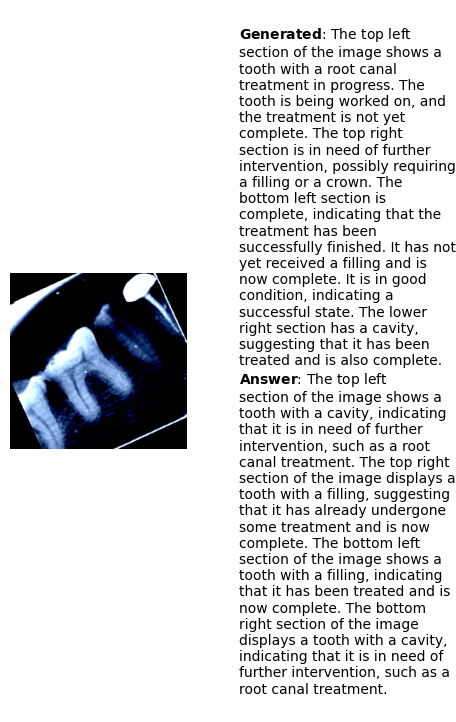

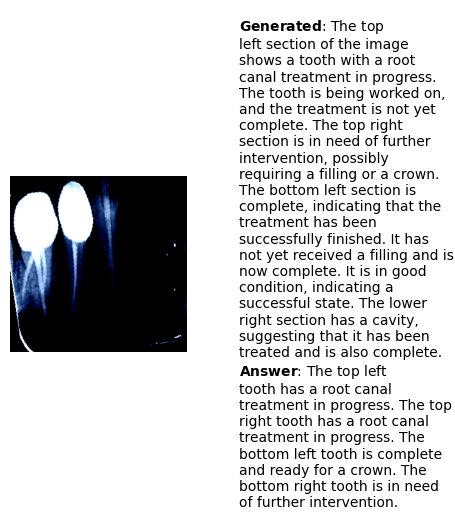

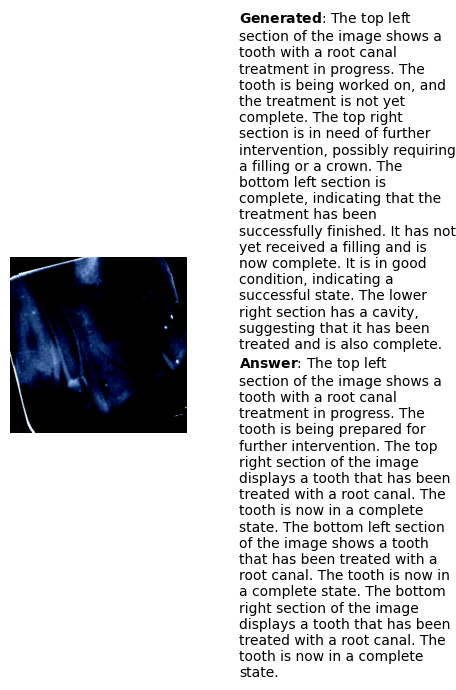

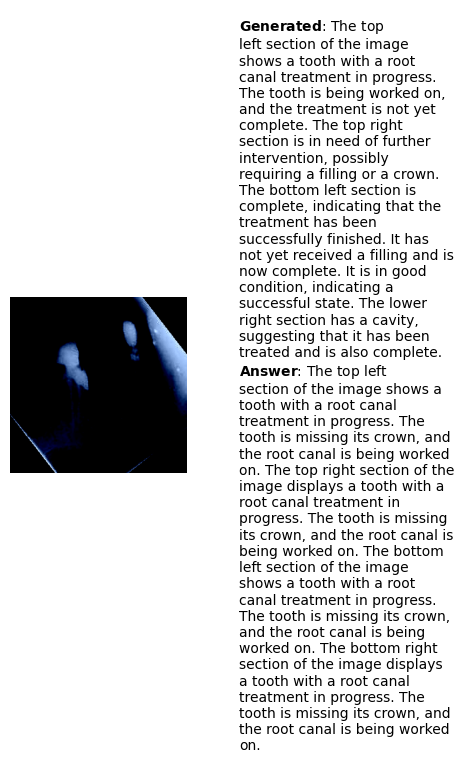

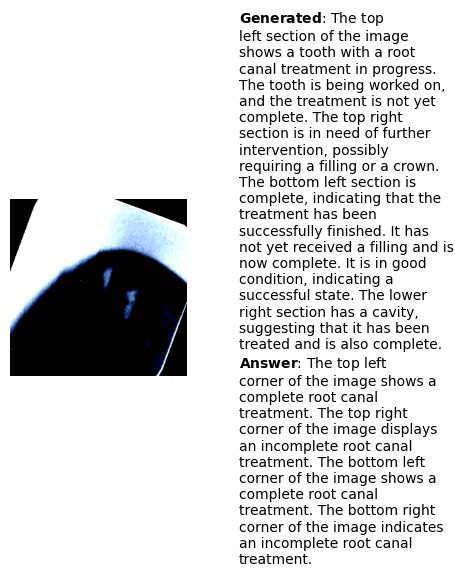

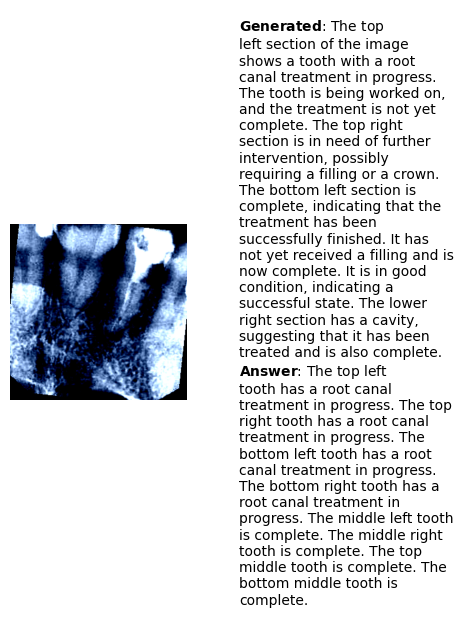

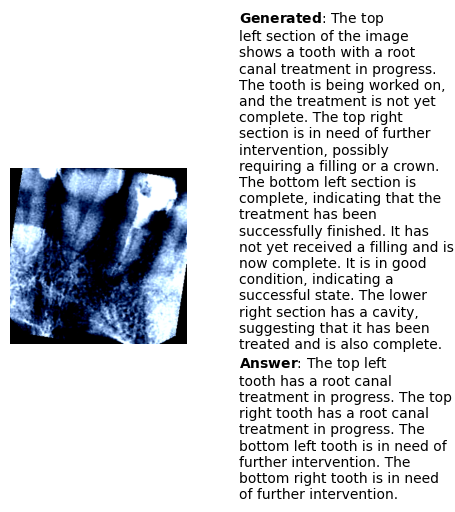

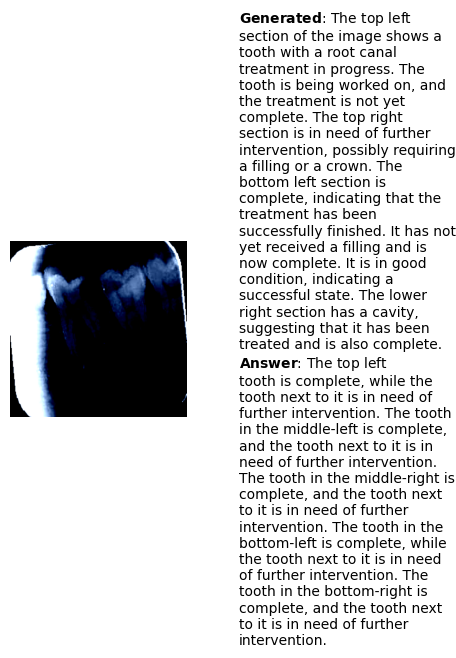

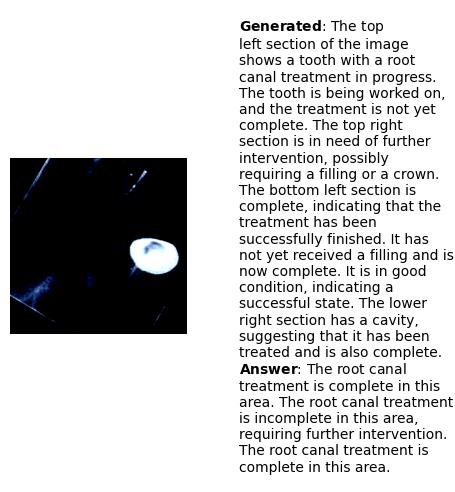

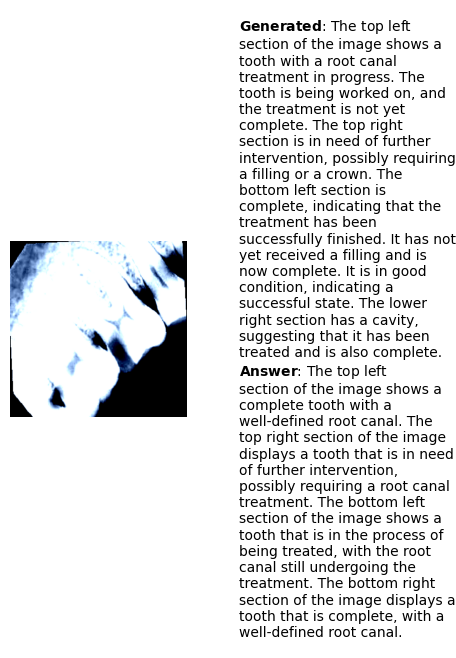

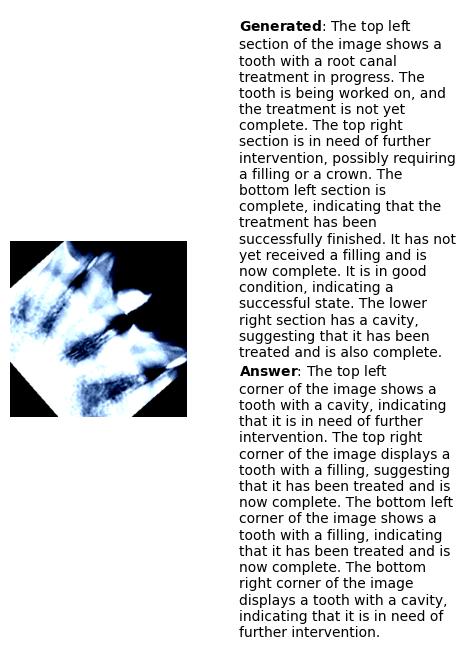

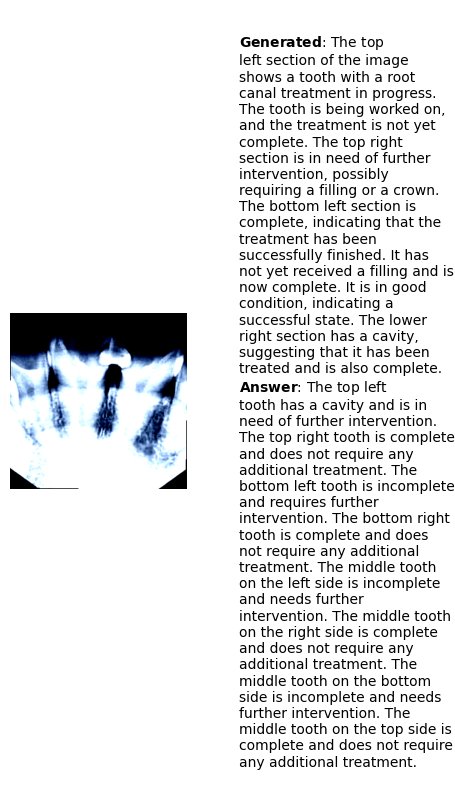

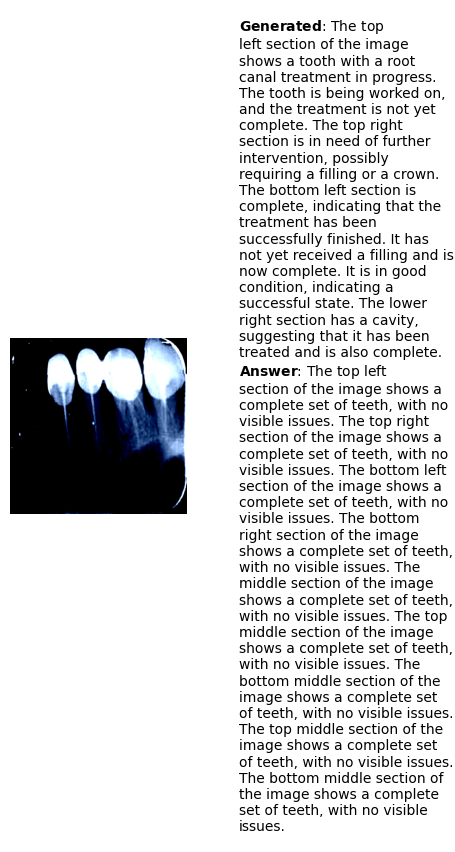

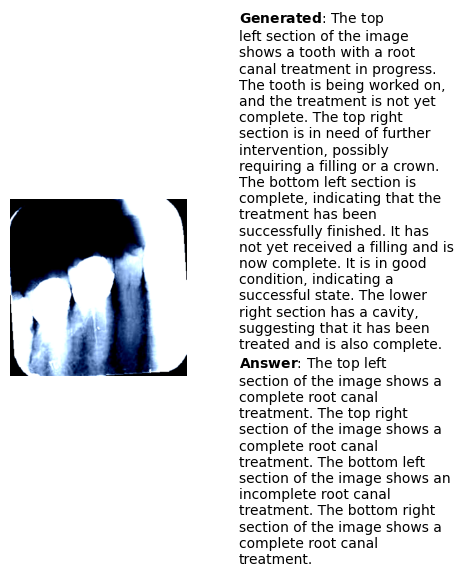

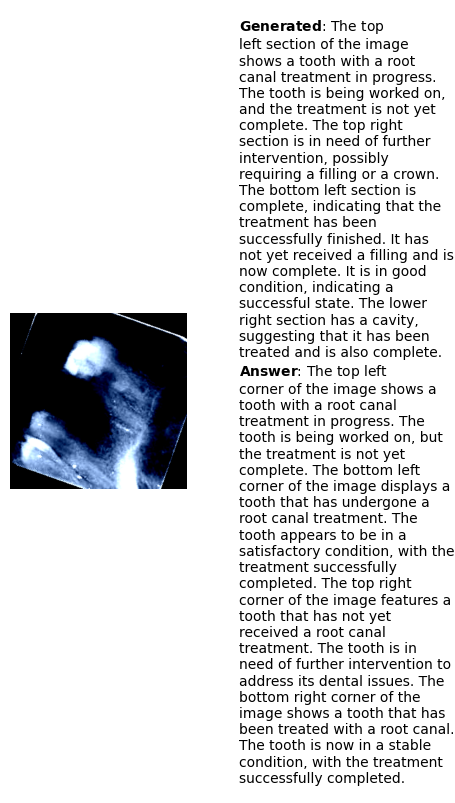

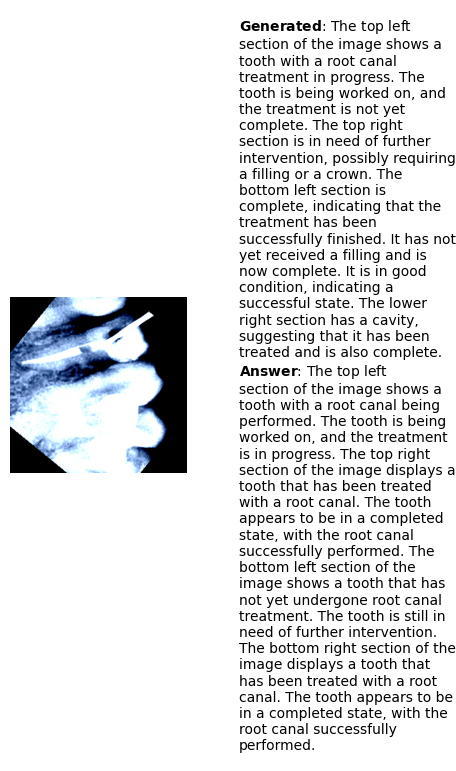

In [17]:
import matplotlib.pyplot as plt

import torch

from tqdm import tqdm



def run_inference(model, processor, data_loader, device):

    model.eval()

    results = []



    for inputs, answers in tqdm(data_loader, desc="Inference"):

        # Move tensors to device

        inputs = {

            key: value.to(device) if key != 'input_ids' else value.to(device).long()

            for key, value in inputs.items()

        }

        # Prepare decoder input ids

        decoder_input_ids = torch.full((inputs['input_ids'].shape[0], 1), processor.tokenizer.bos_token_id, dtype=torch.long, device=device)



        with torch.no_grad():

            # Generate captions

            generated_ids = model.generate(

                input_ids=inputs['input_ids'],

                pixel_values=inputs['pixel_values'],

                max_new_tokens=1024,

                num_beams=3

            )



        # Decode generated IDs to text

        generated_texts = processor.batch_decode(generated_ids, skip_special_tokens=True)



        # Collect results

        for pred, ans, img in zip(generated_texts, answers, inputs['pixel_values']):

            img = img.cpu().permute(1, 2, 0)  # Ensure image is in HWC format for display

            img = img.numpy()  # Convert tensor to numpy array

            results.append({'prediction': pred, 'answer': ans, 'image': img})



    return results



# Run inference on the validation dataset

val_results = run_inference(peft_model, processor, val_loader, DEVICE)



# Display answers and generated captions

for i, result in enumerate(val_results[:20]):

    plt.figure(figsize=(5, 5))



    # Display the image

    plt.subplot(1, 2, 1)

    plt.imshow(result['image'])

    plt.axis('off')

    plt.title(f"")



    # Display the generated caption

    plt.subplot(1, 2, 2)

    plt.text(0.1, 0.5, f"$\\bf{{Generated}}$: {result['prediction']}\n$\\bf{{Answer}}$: {result['answer']}",

             fontsize=10, ha='left', va='center', wrap=True)

    plt.axis('off')

    plt.title(f"")



    plt.show()


In [18]:
# Install all required packages

!pip install scikit-learn rouge-score git+https://github.com/salaniz/pycocoevalcap.git



# Download necessary NLTK data packages for BLEU and METEOR scores

import nltk

nltk.download('punkt')

nltk.download('wordnet')

nltk.download('omw-1.4')



from nltk.translate.bleu_score import corpus_bleu

from rouge_score import rouge_scorer

import pycocoevalcap.bleu.bleu

import pycocoevalcap.meteor.meteor

import pycocoevalcap.cider.cider



# Prepare your predictions and references

predictions = [result['prediction'] for result in val_results]

references = [result['answer'] for result in val_results]



# Convert lists to dictionaries with image IDs as keys

gts = {i: [ref] for i, ref in enumerate(references)}

res = {i: [pred] for i, pred in enumerate(predictions)}



# Evaluate using BLEU Score

bleu_scorer = pycocoevalcap.bleu.bleu.Bleu(4)  # BLEU-4

bleu_score, _ = bleu_scorer.compute_score(gts, res)

print(f"BLEU Score: {bleu_score}")



# Evaluate using METEOR Score (from pycocoevalcap)

meteor_scorer = pycocoevalcap.meteor.meteor.Meteor()

meteor_score, _ = meteor_scorer.compute_score(gts, res)

print(f"METEOR Score: {meteor_score}")



# Evaluate using ROUGE Score

rouge_scorer_obj = rouge_scorer.RougeScorer(['rouge1', 'rouge2', 'rougeL'], use_stemmer=True)

rouge_scores = {'rouge1': 0, 'rouge2': 0, 'rougeL': 0}

num_samples = len(references)



for i in gts:

    scores = rouge_scorer_obj.score(gts[i][0], res[i][0])

    for rouge_key in rouge_scores:

        rouge_scores[rouge_key] += scores[rouge_key].fmeasure



# Average ROUGE Scores

for key in rouge_scores:

    rouge_scores[key] /= num_samples



print(f"ROUGE Scores: {rouge_scores}")



# Evaluate using CIDEr Score

cider_scorer = pycocoevalcap.cider.cider.Cider()

cider_score, _ = cider_scorer.compute_score(gts, res)

print(f"CIDEr Score: {cider_score}")

/opt/conda/lib/python3.10/pty.py:89: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid, fd = os.forkpty()
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


  Cloning https://github.com/salaniz/pycocoevalcap.git to /tmp/pip-req-build-21xjb1u2
  Running command git clone --filter=blob:none --quiet https://github.com/salaniz/pycocoevalcap.git /tmp/pip-req-build-21xjb1u2
  Resolved https://github.com/salaniz/pycocoevalcap.git to commit a24f74c408c918f1f4ec34e9514bc8a76ce41ffd
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... - done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 427.8/427.8 kB 11.8 MB/s eta 0:00:00
  Created wheel for rouge-score: filename=rouge_score-0.1.2-py3-none-any.whl size=24934 sha256=daefcb86c8e4e96f40c6c33cf197ff411f9686b1de37cb99948fafa106c5f7cd
  Stored in directory: /root/.cache/pip/wheels/5f/dd/89/461065a73be61a532ff8599a28e9beef17985c9e9c31e541b4
  Created wheel for pycocoevalcap: filename=pycocoevalcap-1.2-py3-none-any.whl size=104312246 sha256=bd4ff54d69fc578fff05a3eb801c11c4c80716229a00632d7923f97d53a6f8fb
  Stored in directory: /tmp/pip-ephem-wheel-cache-xnkoh7u3/wheels/57/de/9f/7aa9

In [19]:
# Install all required packages

!pip install scikit-learn rouge-score git+https://github.com/salaniz/pycocoevalcap.git autocorrect gensim



# Download necessary NLTK data packages

import nltk

nltk.download('punkt')

nltk.download('wordnet')

nltk.download('omw-1.4')

nltk.download('stopwords')

nltk.download('averaged_perceptron_tagger')



from autocorrect import Speller

from nltk.tokenize import word_tokenize

from nltk.corpus import stopwords

from nltk.stem import PorterStemmer

from nltk import pos_tag

from collections import Counter

import pycocoevalcap.bleu.bleu

import pycocoevalcap.meteor.meteor

import pycocoevalcap.cider.cider

from rouge_score import rouge_scorer

import re

import string



# Initialize spell checker, stemmer, and stop words

spell = Speller()

stemmer = PorterStemmer()

stop_words = set(stopwords.words('english'))



# Function to perform spell correction

def correct_spelling(text):

    return spell(text)



# Function to expand common contractions

contractions = {

    "can't": "cannot", "won't": "will not", "n't": " not", "'re": " are", "'s": " is", "'d": " would", "'ll": " will", "'ve": " have", "'m": " am"

}



def expand_contractions(text):

    for contraction, full_form in contractions.items():

        text = re.sub(contraction, full_form, text)

    return text



# Function for POS filtering to retain meaningful words

def filter_pos(tokens):

    allowed_tags = {'NN', 'VB', 'JJ'}

    return [word for word, tag in pos_tag(tokens) if tag[:2] in allowed_tags]



# Function to remove low-frequency words based on a dataset-wide frequency count

def remove_low_frequency_words(tokens, frequency_dict, threshold=2):

    return [word for word in tokens if frequency_dict[word] > threshold]



# Preprocessing function with advanced techniques

def preprocess_text(text, frequency_dict):

    # Correct spelling errors

    text = correct_spelling(text)

    

    # Lowercase the text

    text = text.lower()



    # Expand contractions

    text = expand_contractions(text)

    

    # Remove digits

    text = re.sub(r'\d+', '', text)

    

    # Remove special characters

    text = re.sub(r'[^a-zA-Z\s]', '', text)



    # Tokenize the text

    tokens = word_tokenize(text)



    # Remove punctuation and stop words

    tokens = [word for word in tokens if word not in stop_words and word.isalpha()]

    

    # POS filtering to retain nouns, verbs, adjectives

    tokens = filter_pos(tokens)



    # Apply stemming

    tokens = [stemmer.stem(word) for word in tokens]



    # Remove low-frequency words

    tokens = remove_low_frequency_words(tokens, frequency_dict)



    return ' '.join(tokens).strip()



# Build a frequency dictionary from your dataset

def build_frequency_dict(texts):

    all_words = []

    for text in texts:

        tokens = word_tokenize(text.lower())

        all_words.extend([word for word in tokens if word.isalpha()])

    return Counter(all_words)



# Prepare your predictions and references

predictions = [result['prediction'] for result in val_results]

references = [result['answer'] for result in val_results]



# Build frequency dictionary for low-frequency word removal

all_captions = predictions + references

frequency_dict = build_frequency_dict(all_captions)



# Preprocess predictions and references

preprocessed_predictions = [preprocess_text(pred, frequency_dict) for pred in predictions]

preprocessed_references = [preprocess_text(ref, frequency_dict) for ref in references]



# Convert lists to dictionaries with image IDs as keys

gts = {i: [ref] for i, ref in enumerate(preprocessed_references)}

res = {i: [pred] for i, pred in enumerate(preprocessed_predictions)}



# Evaluate using BLEU Score

bleu_scorer = pycocoevalcap.bleu.bleu.Bleu(4)  # BLEU-4

bleu_score, _ = bleu_scorer.compute_score(gts, res)

print(f"BLEU Score: {bleu_score}")



# Evaluate using METEOR Score

meteor_scorer = pycocoevalcap.meteor.meteor.Meteor()

meteor_score, _ = meteor_scorer.compute_score(gts, res)

print(f"METEOR Score: {meteor_score}")



# Evaluate using ROUGE Score

rouge_scorer_obj = rouge_scorer.RougeScorer(['rouge1', 'rouge2', 'rougeL'], use_stemmer=True)

rouge_scores = {'rouge1': 0, 'rouge2': 0, 'rougeL': 0}

num_samples = len(preprocessed_references)



for i in gts:

    scores = rouge_scorer_obj.score(gts[i][0], res[i][0])

    for rouge_key in rouge_scores:

        rouge_scores[rouge_key] += scores[rouge_key].fmeasure



# Average ROUGE Scores

for key in rouge_scores:

    rouge_scores[key] /= num_samples



print(f"ROUGE Scores: {rouge_scores}")



# Evaluate using CIDEr Score

cider_scorer = pycocoevalcap.cider.cider.Cider()

cider_score, _ = cider_scorer.compute_score(gts, res)

print(f"CIDEr Score: {cider_score}")

/opt/conda/lib/python3.10/pty.py:89: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid, fd = os.forkpty()
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


  Cloning https://github.com/salaniz/pycocoevalcap.git to /tmp/pip-req-build-p1r4imfs
  Running command git clone --filter=blob:none --quiet https://github.com/salaniz/pycocoevalcap.git /tmp/pip-req-build-p1r4imfs
  Resolved https://github.com/salaniz/pycocoevalcap.git to commit a24f74c408c918f1f4ec34e9514bc8a76ce41ffd
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 622.8/622.8 kB 14.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... - done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.6/60.6 kB 3.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 38.6/38.6 MB 45.0 MB/s eta 0:00:00
  Created wheel for autocorrect: filename=autocorrect-2.6.1-py3-none-any.whl size=622363 sha256=9c1d518c137ced30f1d5b84db528a35c7f534b5232472d19b11db230d9346fbc
  Stored in directory: /root/.cache/pip/wheels/b5/7b/6d/b76b29ce11ff8e2521c8c7dd0e5bfee4fb1789d76193124343
Successfully built autocorrect
  Attempting uninstall: scipy
    Found existing insta